In [ ]:
from IPython.display import Image

!pip install -q -U einops datasets matplotlib tqdm

!pip install --upgrade Pillow

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, repeat

import torch
from torch import nn, einsum
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q -U pytorch_lightning

In [ ]:
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from contextlib import contextmanager

In [ ]:
!pip install -q -U hiddenlayer

In [ ]:
# load state_dict from gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Stage 1: Define AutoEncoder (VQInference)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import einsum
from einops import rearrange

In [ ]:
class VectorQuantizer(nn.Module):
    """
    Improved version over VectorQuantizer, can be used as a drop-in replacement. Mostly
    avoids costly matrix multiplications and allows for post-hoc remapping of indices.
    """
    # NOTE: due to a bug the beta term was applied to the wrong term. for
    # backwards compatibility we use the buggy version by default, but you can
    # specify legacy=False to fix it.
    def __init__(self, n_e, e_dim, beta, remap=None, unknown_index="random",
                 sane_index_shape=False, legacy=True):
        super().__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.legacy = legacy

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

        self.remap = remap
        if self.remap is not None:
            self.register_buffer("used", torch.tensor(np.load(self.remap)))
            self.re_embed = self.used.shape[0]
            self.unknown_index = unknown_index # "random" or "extra" or integer
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed = self.re_embed+1
            print(f"Remapping {self.n_e} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = n_e

        self.sane_index_shape = sane_index_shape

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        match = (inds[:,:,None]==used[None,None,...]).long()
        new = match.argmax(-1)
        unknown = match.sum(2)<1
        if self.unknown_index == "random":
            new[unknown]=torch.randint(0,self.re_embed,size=new[unknown].shape).to(device=new.device)
        else:
            new[unknown] = self.unknown_index
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        if self.re_embed > self.used.shape[0]: # extra token
            inds[inds>=self.used.shape[0]] = 0 # simply set to zero
        back=torch.gather(used[None,:][inds.shape[0]*[0],:], 1, inds)
        return back.reshape(ishape)

    def forward(self, z, temp=None, rescale_logits=False, return_logits=False):
        assert temp is None or temp==1.0, "Only for interface compatible with Gumbel"
        assert rescale_logits==False, "Only for interface compatible with Gumbel"
        assert return_logits==False, "Only for interface compatible with Gumbel"
        # reshape z -> (batch, height, width, channel) and flatten
        z = rearrange(z, 'b c h w -> b h w c').contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.einsum('bd,dn->bn', z_flattened, rearrange(self.embedding.weight, 'n d -> d n'))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)
        perplexity = None
        min_encodings = None

        # compute loss for embedding
        if not self.legacy:
            loss = self.beta * torch.mean((z_q.detach()-z)**2) + \
                   torch.mean((z_q - z.detach()) ** 2)
        else:
            loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
                   torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # reshape back to match original input shape
        z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()

        if self.remap is not None:
            min_encoding_indices = min_encoding_indices.reshape(z.shape[0],-1) # add batch axis
            min_encoding_indices = self.remap_to_used(min_encoding_indices)
            min_encoding_indices = min_encoding_indices.reshape(-1,1) # flatten

        if self.sane_index_shape:
            min_encoding_indices = min_encoding_indices.reshape(
                z_q.shape[0], z_q.shape[2], z_q.shape[3])

        return z_q, loss, (perplexity, min_encodings, min_encoding_indices)

    def get_codebook_entry(self, indices, shape):
        # shape specifying (batch, height, width, channel)
        if self.remap is not None:
            indices = indices.reshape(shape[0],-1) # add batch axis
            indices = self.unmap_to_all(indices)
            indices = indices.reshape(-1) # flatten again

        # get quantized latent vectors
        z_q = self.embedding(indices)

        if shape is not None:
            z_q = z_q.view(shape)
            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q

In [ ]:
 # helpers for Encoder() and Decoder()
class LinearAttention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

  def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)  
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels,
                                             out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:,:,None,None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels, num_groups=8):
    # return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)


class LinAttnBlock(LinearAttention):
    """to match AttnBlock usage"""
    def __init__(self, in_channels):
        super().__init__(dim=in_channels, heads=1, dim_head=in_channels)


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1)   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1)   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_

def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "linear", "none"], f'attn_type {attn_type} unknown'
    print(f"making attention of type '{attn_type}' with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        return LinAttnBlock(in_channels)


class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0,1,0,1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,1,2,2,4,4), num_res_blocks,
                 attn_resolutions=(16,8), dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        2*z_channels if double_z else z_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        # timestep embedding
        temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

In [ ]:
class Decoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,1,2,2,4,4), num_res_blocks,
                 attn_resolutions=(16,8), dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, give_pre_end=False, tanh_out=False, use_linear_attn=False,
                 attn_type="vanilla", **ignorekwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels
        self.give_pre_end = give_pre_end
        self.tanh_out = tanh_out

        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1,)+tuple(ch_mult)
        block_in = ch*ch_mult[self.num_resolutions-1]
        curr_res = resolution // 2**(self.num_resolutions-1)
        self.z_shape = (1,z_channels,curr_res,curr_res)
        print("Working with z of shape {} = {} dimensions.".format(
            self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(z_channels,
                                       block_in,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, z):
        #assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        # timestep embedding
        temb = None

        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](h, temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        if self.give_pre_end:
            return h

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        if self.tanh_out:
            h = torch.tanh(h)
        return h

In [ ]:
import torch
import numpy as np


class AbstractDistribution:
    def sample(self):
        raise NotImplementedError()

    def mode(self):
        raise NotImplementedError()


class DiracDistribution(AbstractDistribution):
    def __init__(self, value):
        self.value = value

    def sample(self):
        return self.value

    def mode(self):
        return self.value


class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2)
                                       + self.var - 1.0 - self.logvar,
                                       dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var - 1.0 - self.logvar + other.logvar,
                    dim=[1, 2, 3])

    def nll(self, sample, dims=[1,2,3]):
        if self.deterministic:
            return torch.Tensor([0.])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(
            logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var,
            dim=dims)

    def mode(self):
        return self.mean


def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    source: https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/losses.py#L12
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

In [ ]:
import importlib

import torch
import numpy as np

from inspect import isfunction
from PIL import Image, ImageDraw, ImageFont


def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

In [ ]:
class VQModel(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 n_embed,
                 embed_dim,
                 ckpt_path=None,
                 ignore_keys=[],
                 image_key="image",
                 colorize_nlabels=None,
                 monitor=None,
                 batch_resize_range=None,
                 scheduler_config=None,
                 lr_g_factor=1.0,
                 remap=None,
                 sane_index_shape=False, # tell vector quantizer to return indices as bhw
                 use_ema=False
                 ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.image_key = image_key
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25,
                                        remap=remap,
                                        sane_index_shape=sane_index_shape)
        self.quant_conv = torch.nn.Conv2d(ddconfig["z_channels"], embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        if colorize_nlabels is not None:
            assert type(colorize_nlabels)==int
            self.register_buffer("colorize", torch.randn(3, colorize_nlabels, 1, 1))
        if monitor is not None:
            self.monitor = monitor
        self.batch_resize_range = batch_resize_range
        if self.batch_resize_range is not None:
            print(f"{self.__class__.__name__}: Using per-batch resizing in range {batch_resize_range}.")

        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys)
        self.scheduler_config = scheduler_config
        self.lr_g_factor = lr_g_factor

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.parameters())
            self.model_ema.copy_to(self)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def init_from_ckpt(self, path, ignore_keys=list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        missing, unexpected = self.load_state_dict(sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
            print(f"Unexpected Keys: {unexpected}")

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self)

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        quant, emb_loss, info = self.quantize(h)
        return quant, emb_loss, info

    def encode_to_prequant(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, quant):
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec

    def decode_code(self, code_b):
        quant_b = self.quantize.embed_code(code_b)
        dec = self.decode(quant_b)
        return dec

    def forward(self, input, return_pred_indices=False):
        quant, diff, (_,_,ind) = self.encode(input)
        dec = self.decode(quant)
        if return_pred_indices:
            return dec, diff, ind
        return dec, diff

    def get_input(self, batch, k):
        print('hello')
        #comment
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        if self.batch_resize_range is not None:
            lower_size = self.batch_resize_range[0]
            upper_size = self.batch_resize_range[1]
            if self.global_step <= 4:
                # do the first few batches with max size to avoid later oom
                new_resize = upper_size
            else:
                new_resize = np.random.choice(np.arange(lower_size, upper_size+16, 16))
            if new_resize != x.shape[2]:
                x = F.interpolate(x, size=new_resize, mode="bicubic")
            x = x.detach()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        # https://github.com/pytorch/pytorch/issues/37142
        # try not to fool the heuristics
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)

        if optimizer_idx == 0:
            # autoencode
            aeloss, log_dict_ae = self.loss(qloss, x, xrec, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train",
                                            predicted_indices=ind)

            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            return aeloss

        if optimizer_idx == 1:
            # discriminator
            discloss, log_dict_disc = self.loss(qloss, x, xrec, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train")
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            return discloss

    def validation_step(self, batch, batch_idx):
        log_dict = self._validation_step(batch, batch_idx)
        with self.ema_scope():
            log_dict_ema = self._validation_step(batch, batch_idx, suffix="_ema")
        return log_dict

    def _validation_step(self, batch, batch_idx, suffix=""):
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)
        aeloss, log_dict_ae = self.loss(qloss, x, xrec, 0,
                                        self.global_step,
                                        last_layer=self.get_last_layer(),
                                        split="val"+suffix,
                                        predicted_indices=ind
                                        )

        discloss, log_dict_disc = self.loss(qloss, x, xrec, 1,
                                            self.global_step,
                                            last_layer=self.get_last_layer(),
                                            split="val"+suffix,
                                            predicted_indices=ind
                                            )
        rec_loss = log_dict_ae[f"val{suffix}/rec_loss"]
        self.log(f"val{suffix}/rec_loss", rec_loss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log(f"val{suffix}/aeloss", aeloss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        if version.parse(pl.__version__) >= version.parse('1.4.0'):
            del log_dict_ae[f"val{suffix}/rec_loss"]
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr_d = self.learning_rate
        lr_g = self.lr_g_factor*self.learning_rate
        print("lr_d", lr_d)
        print("lr_g", lr_g)
        opt_ae = torch.optim.Adam(list(self.encoder.parameters())+
                                  list(self.decoder.parameters())+
                                  list(self.quantize.parameters())+
                                  list(self.quant_conv.parameters())+
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr_g, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(),
                                    lr=lr_d, betas=(0.5, 0.9))

        if self.scheduler_config is not None:
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt_ae, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                },
                {
                    'scheduler': LambdaLR(opt_disc, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                },
            ]
            return [opt_ae, opt_disc], scheduler
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    def log_images(self, batch, only_inputs=False, plot_ema=False, **kwargs):
        log = dict()
        x = self.get_input(batch, self.image_key)
        x = x.to(self.device)
        if only_inputs:
            log["inputs"] = x
            return log
        xrec, _ = self(x)
        if x.shape[1] > 3:
            # colorize with random projection
            assert xrec.shape[1] > 3
            x = self.to_rgb(x)
            xrec = self.to_rgb(xrec)
        log["inputs"] = x
        log["reconstructions"] = xrec
        if plot_ema:
            with self.ema_scope():
                xrec_ema, _ = self(x)
                if x.shape[1] > 3: xrec_ema = self.to_rgb(xrec_ema)
                log["reconstructions_ema"] = xrec_ema
        return log

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        if not hasattr(self, "colorize"):
            self.register_buffer("colorize", torch.randn(3, x.shape[1], 1, 1).to(x))
        x = F.conv2d(x, weight=self.colorize)
        x = 2.*(x-x.min())/(x.max()-x.min()) - 1.
        return x


class VQModelInterface(VQModel):
    def __init__(self, embed_dim, *args, **kwargs):
        super().__init__(embed_dim=embed_dim, *args, **kwargs)
        self.embed_dim = embed_dim

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, h, force_not_quantize=False):
        # also go through quantization layer
        if not force_not_quantize:
            quant, emb_loss, info = self.quantize(h)
        else:
            quant = h
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec

## Section 1.1 AutoEncoderKL Attempt 1

In [ ]:
class AutoencoderKL(nn.Module):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 embed_dim,
                 ckpt_path=None,
                 ignore_keys=[],
                 image_key="image",
                 colorize_nlabels=None,
                 monitor=None,
                 ):
        super().__init__()
        self.image_key = image_key
        print(f'DDCONFIG: {ddconfig}')
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = LPIPSWithDiscriminator(disc_start=lossconfig["params"]["disc_start"], kl_weight=lossconfig["params"]["kl_weight"], disc_weight=lossconfig["params"]["disc_weight"])
        #self.loss = instantiate_from_config(lossconfig)
        assert ddconfig["double_z"]
        self.quant_conv = torch.nn.Conv2d(2*ddconfig["z_channels"], 2*embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        self.embed_dim = embed_dim
        self.learning_rate = 4.5e-6
        self.global_net_step = 0

        if colorize_nlabels is not None:
            assert type(colorize_nlabels)==int
            self.register_buffer("colorize", torch.randn(3, colorize_nlabels, 1, 1))
        if monitor is not None:
            self.monitor = monitor
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys)

    def init_from_ckpt(self, path, ignore_keys=list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        self.load_state_dict(sd, strict=False)
        print(f"Restored from {path}")

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, input, sample_posterior=True):
        self.global_net_step += 1
        posterior = self.encode(input)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        return dec, posterior

    # def get_input(self, batch, k):
    #     x = batch[k]
    #     if len(x.shape) == 3:
    #         x = x[..., None]
    #     x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
    #     return x
    
    def get_input(self, batch, k):
        # x = batch.view(12, 784)
        # x = x.to(DEVICE)
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)

        if optimizer_idx == 0:
            # train encoder+decoder+logvar
            aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_net_step,
                                            last_layer=self.get_last_layer(), split="train")
            # self.log("aeloss", aeloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            # self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return aeloss

        if optimizer_idx == 1:
            # train the discriminator
            discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_net_step,
                                                last_layer=self.get_last_layer(), split="train")

            # self.log("discloss", discloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            # self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return discloss

    def validation_step(self, batch, batch_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)
        aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, 0, self.global_net_step,
                                        last_layer=self.get_last_layer(), split="val")

        discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, 1, self.global_net_step,
                                            last_layer=self.get_last_layer(), split="val")

        # self.log("val/rec_loss", log_dict_ae["val/rec_loss"])
        # self.log_dict(log_dict_ae)
        # self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr = self.learning_rate
        opt_ae = torch.optim.Adam(list(self.encoder.parameters())+
                                  list(self.decoder.parameters())+
                                  list(self.quant_conv.parameters())+
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(),
                                    lr=lr, betas=(0.5, 0.9))
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    @torch.no_grad()
    def log_images(self, batch, only_inputs=False, **kwargs):
        log = dict()
        x = self.get_input(batch, self.image_key)
        x = x.to(self.device)
        if not only_inputs:
            xrec, posterior = self(x)
            if x.shape[1] > 3:
                # colorize with random projection
                assert xrec.shape[1] > 3
                x = self.to_rgb(x)
                xrec = self.to_rgb(xrec)
            log["samples"] = self.decode(torch.randn_like(posterior.sample()))
            log["reconstructions"] = xrec
        log["inputs"] = x
        return log

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        if not hasattr(self, "colorize"):
            self.register_buffer("colorize", torch.randn(3, x.shape[1], 1, 1).to(x))
        x = F.conv2d(x, weight=self.colorize)
        x = 2.*(x-x.min())/(x.max()-x.min()) - 1.
        return x


In [ ]:
temp = torch.Tensor([1,2,3])
temp

tensor([1., 2., 3.])

In [ ]:
np.array(temp)

array([1., 2., 3.], dtype=float32)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from collections import namedtuple

import os, hashlib
import requests
from tqdm import tqdm

URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}

MD5_MAP = {
    "vgg_lpips": "d507d7349b931f0638a25a48a722f98a"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def md5_hash(path):
    with open(path, "rb") as f:
        content = f.read()
    return hashlib.md5(content).hexdigest()


def get_ckpt_path(name, root, check=False):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path) or (check and not md5_hash(path) == MD5_MAP[name]):
        print("Downloading {} model from {} to {}".format(name, URL_MAP[name], path))
        download(URL_MAP[name], path)
        md5 = md5_hash(path)
        assert md5 == MD5_MAP[name], md5
    return path


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


class NetLinLayer(nn.Module):
    """ A single linear layer which does a 1x1 conv """
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()
        layers = [nn.Dropout(), ] if (use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False), ]
        self.model = nn.Sequential(*layers)

class vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out


class LPIPS(nn.Module):
    # Learned perceptual metric
    def __init__(self, use_dropout=True):
        super().__init__()
        self.scaling_layer = ScalingLayer()
        self.chns = [64, 128, 256, 512, 512]  # vg16 features
        self.net = vgg16(pretrained=True, requires_grad=False)
        self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
        self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
        self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
        self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
        self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
        self.load_from_pretrained()
        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "taming/modules/autoencoder/lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)
        print("loaded pretrained LPIPS loss from {}".format(ckpt))

    @classmethod
    def from_pretrained(cls, name="vgg_lpips"):
        if name != "vgg_lpips":
            raise NotImplementedError
        model = cls()
        ckpt = get_ckpt_path(name)
        model.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)
        return model

    def forward(self, input, target):
        in0_input, in1_input = (self.scaling_layer(input), self.scaling_layer(target))
        outs0, outs1 = self.net(in0_input), self.net(in1_input)
        feats0, feats1, diffs = {}, {}, {}
        lins = [self.lin0, self.lin1, self.lin2, self.lin3, self.lin4]
        for kk in range(len(self.chns)):
            feats0[kk], feats1[kk] = normalize_tensor(outs0[kk]), normalize_tensor(outs1[kk])
            diffs[kk] = (feats0[kk] - feats1[kk]) ** 2

        res = [spatial_average(lins[kk].model(diffs[kk]), keepdim=True) for kk in range(len(self.chns))]
        val = res[0]
        for l in range(1, len(self.chns)):
            val += res[l]
        return val


def normalize_tensor(x,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(x**2,dim=1,keepdim=True))
    return x/(norm_factor+eps)


def spatial_average(x, keepdim=True):
    return x.mean([2,3],keepdim=keepdim)


class LPIPSWithDiscriminator(nn.Module):
    def __init__(self, disc_start, logvar_init=0.0, kl_weight=1.0, pixelloss_weight=1.0,
                 disc_num_layers=3, disc_in_channels=3, disc_factor=1.0, disc_weight=1.0,
                 perceptual_weight=0.0, use_actnorm=False, disc_conditional=False,
                 disc_loss="hinge"):

        super().__init__()
        assert disc_loss in ["hinge", "vanilla"]
        self.kl_weight = kl_weight
        self.pixel_weight = pixelloss_weight
        self.perceptual_loss = LPIPS().eval()
        self.perceptual_weight = perceptual_weight
        # output log variance
        self.logvar = nn.Parameter(torch.ones(size=()) * logvar_init)

        self.discriminator = NLayerDiscriminator(input_nc=disc_in_channels,
                                                 n_layers=disc_num_layers,
                                                 use_actnorm=use_actnorm
                                                 ).apply(weights_init)
        self.discriminator_iter_start = disc_start
        self.disc_loss = hinge_d_loss if disc_loss == "hinge" else vanilla_d_loss
        self.disc_factor = disc_factor
        print(f'****disc_factor: {self.disc_factor}')
        self.discriminator_weight = disc_weight
        self.disc_conditional = disc_conditional

    def calculate_adaptive_weight(self, nll_loss, g_loss, last_layer=None):
        if last_layer is not None:
            nll_grads = torch.autograd.grad(nll_loss, last_layer, retain_graph=True)[0]
            g_grads = torch.autograd.grad(g_loss, last_layer, retain_graph=True)[0]
        else:
            nll_grads = torch.autograd.grad(nll_loss, self.last_layer[0], retain_graph=True)[0]
            g_grads = torch.autograd.grad(g_loss, self.last_layer[0], retain_graph=True)[0]

        d_weight = torch.norm(nll_grads) / (torch.norm(g_grads) + 1e-4)
        d_weight = torch.clamp(d_weight, 0.0, 1e4).detach()
        d_weight = d_weight * self.discriminator_weight
        return d_weight

    def forward(self, inputs, reconstructions, posteriors, optimizer_idx,
                global_step, last_layer=None, cond=None, split="train",
                weights=None):
        rec_loss = torch.abs(inputs.contiguous() - reconstructions.contiguous())
        if self.perceptual_weight > 0:
            #p_loss = self.perceptual_loss(inputs.contiguous(), reconstructions.contiguous())
            p_loss = 0.0
            rec_loss = rec_loss + self.perceptual_weight * p_loss

        nll_loss = rec_loss / torch.exp(self.logvar) + self.logvar
        weighted_nll_loss = nll_loss
        if weights is not None:
            weighted_nll_loss = weights*nll_loss
        weighted_nll_loss = torch.sum(weighted_nll_loss) / weighted_nll_loss.shape[0]
        nll_loss = torch.sum(nll_loss) / nll_loss.shape[0]
        kl_loss = posteriors.kl()
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

        # now the GAN part
        if optimizer_idx == 0:
            # generator update
            if cond is None:
                assert not self.disc_conditional
                logits_fake = self.discriminator(reconstructions.contiguous())
            else:
                assert self.disc_conditional
                logits_fake = self.discriminator(torch.cat((reconstructions.contiguous(), cond), dim=1))
            g_loss = -torch.mean(logits_fake)

            if self.disc_factor > 0.0:
                try:
                    d_weight = self.calculate_adaptive_weight(nll_loss, g_loss, last_layer=last_layer)
                except RuntimeError:
                    assert not self.training
                    d_weight = torch.tensor(0.0)
            else:
                d_weight = torch.tensor(0.0)

            disc_factor = adopt_weight(self.disc_factor, global_step, threshold=self.discriminator_iter_start)
            loss = weighted_nll_loss + self.kl_weight * kl_loss + d_weight * disc_factor * g_loss

            log = {"{}/total_loss".format(split): loss.clone().detach().mean(), "{}/logvar".format(split): self.logvar.detach(),
                   "{}/kl_loss".format(split): kl_loss.detach().mean(), "{}/nll_loss".format(split): nll_loss.detach().mean(),
                   "{}/rec_loss".format(split): rec_loss.detach().mean(),
                   "{}/d_weight".format(split): d_weight.detach(),
                   "{}/disc_factor".format(split): torch.tensor(disc_factor),
                   "{}/g_loss".format(split): g_loss.detach().mean(),
                   }
            return loss, log

        if optimizer_idx == 1:
            # second pass for discriminator update
            if cond is None:
                logits_real = self.discriminator(inputs.contiguous().detach())
                logits_fake = self.discriminator(reconstructions.contiguous().detach())
            else:
                logits_real = self.discriminator(torch.cat((inputs.contiguous().detach(), cond), dim=1))
                logits_fake = self.discriminator(torch.cat((reconstructions.contiguous().detach(), cond), dim=1))

            disc_factor = adopt_weight(self.disc_factor, global_step, threshold=self.discriminator_iter_start)
            d_loss = disc_factor * self.disc_loss(logits_real, logits_fake)

            log = {"{}/disc_loss".format(split): d_loss.clone().detach().mean(),
                   "{}/logits_real".format(split): logits_real.detach().mean(),
                   "{}/logits_fake".format(split): logits_fake.detach().mean()
                   }
            return d_loss, log

In [ ]:
# loss helpers
import functools


def count_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params


class ActNorm(nn.Module):
    def __init__(self, num_features, logdet=False, affine=True,
                 allow_reverse_init=False):
        assert affine
        super().__init__()
        self.logdet = logdet
        self.loc = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.allow_reverse_init = allow_reverse_init

        self.register_buffer('initialized', torch.tensor(0, dtype=torch.uint8))

    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1, 0, 2, 3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )

            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))

    def forward(self, input, reverse=False):
        if reverse:
            return self.reverse(input)
        if len(input.shape) == 2:
            input = input[:,:,None,None]
            squeeze = True
        else:
            squeeze = False

        _, _, height, width = input.shape

        if self.training and self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)

        h = self.scale * (input + self.loc)

        if squeeze:
            h = h.squeeze(-1).squeeze(-1)

        if self.logdet:
            log_abs = torch.log(torch.abs(self.scale))
            logdet = height*width*torch.sum(log_abs)
            logdet = logdet * torch.ones(input.shape[0]).to(input)
            return h, logdet

        return h

    def reverse(self, output):
        if self.training and self.initialized.item() == 0:
            if not self.allow_reverse_init:
                raise RuntimeError(
                    "Initializing ActNorm in reverse direction is "
                    "disabled by default. Use allow_reverse_init=True to enable."
                )
            else:
                self.initialize(output)
                self.initialized.fill_(1)

        if len(output.shape) == 2:
            output = output[:,:,None,None]
            squeeze = True
        else:
            squeeze = False

        h = output / self.scale - self.loc

        if squeeze:
            h = h.squeeze(-1).squeeze(-1)
        return h


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator as in Pix2Pix
        --> see https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
    """
    def __init__(self, input_nc=3, ndf=64, n_layers=3, use_actnorm=False):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if not use_actnorm:
            norm_layer = nn.BatchNorm2d
        else:
            norm_layer = ActNorm
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func != nn.BatchNorm2d
        else:
            use_bias = norm_layer != nn.BatchNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.main = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.main(input)


class DummyLoss(nn.Module):
    def __init__(self):
        super().__init__()


def adopt_weight(weight, global_step, threshold=0, value=0.):
    if global_step < threshold:
        weight = value
    return weight


def hinge_d_loss(logits_real, logits_fake):
    loss_real = torch.mean(F.relu(1. - logits_real))
    loss_fake = torch.mean(F.relu(1. + logits_fake))
    d_loss = 0.5 * (loss_real + loss_fake)
    return d_loss


def vanilla_d_loss(logits_real, logits_fake):
    d_loss = 0.5 * (
        torch.mean(torch.nn.functional.softplus(-logits_real)) +
        torch.mean(torch.nn.functional.softplus(logits_fake)))
    return d_loss




# Stage 2: Train AutoEncoder

In [ ]:
autoencoder_config = {"base_learning_rate": 4.5e-6,
                      "target": "ldm.models.autoencoder.AutoencoderKL",
                      "params": {
                          "monitor": "val/rec_loss",
                          "embed_dim": 3,
                          "loss_config": {
                              "target": "ldm.modules.losses.LPIPSWithDiscriminator",
                              "params": {
                                  "disc_start": 50001,
                                  "kl_weight": 0.000001,
                                  "disc_weight": 0.5
                              }
                          },
                          "ddconfig": {
                             "double_z": True,
                              "z_channels": 3,
                              "resolution": 256,
                              "in_channels": 3,
                              "out_ch": 3,
                              "ch": 128,
                              "ch_mult": [ 1,2,4 ],  # num_down = len(ch_mult)-1
                              "num_res_blocks": 2,
                              "attn_resolutions": [ ],
                              "dropout": 0.0 
                          },
                      }
                      }

In [ ]:
# config for MNIST data (28, 28, 1)

autoencoder_config = {"base_learning_rate": 4.5e-6,
                      "target": "ldm.models.autoencoder.AutoencoderKL",
                      "params": {
                          "monitor": "val/rec_loss",
                          "embed_dim": 1,
                          "loss_config": {
                              "target": "ldm.modules.losses.LPIPSWithDiscriminator",
                              "params": {
                                  "disc_start": 50001,
                                  "kl_weight": 0.000001,
                                  "disc_weight": 0.5
                              }
                          },
                          "ddconfig": {
                              "double_z": True,
                              "z_channels": 1,
                              "resolution": 28,
                              "in_channels": 1,
                              "out_ch": 1,
                              "ch": 16,
                              "ch_mult": [ 1,2,4 ],  # num_down = len(ch_mult)-1
                              "num_res_blocks": 2,
                              "attn_resolutions": [ ],
                              "dropout": 0.0 
                          },
                      },
                      }

In [ ]:
# config for 2D-Microstructure data (256, 256, 3)

autoencoder_config = {"base_learning_rate": 4.5e-6,
                      "target": "ldm.models.autoencoder.AutoencoderKL",
                      "params": {
                          "monitor": "val/rec_loss",
                          "embed_dim": 64,
                          "loss_config": {
                              "target": "ldm.modules.losses.LPIPSWithDiscriminator",
                              "params": {
                                  "disc_start": 50001,
                                  "kl_weight": 0.000001,
                                  "disc_weight": 0.5
                              }
                          },
                          "ddconfig": {
                              "double_z": True,
                              "z_channels": 64,
                              "resolution": 256,
                              "in_channels": 3,
                              "out_ch": 3,
                              "ch": 128,
                              "ch_mult": [ 1,1,2,2,4,4 ],  # num_down = len(ch_mult)-1
                              "num_res_blocks": 2,
                              "attn_resolutions": [16,8],
                              "dropout": 0.0 
                          },
                      },
                      }

In [ ]:
autoencoder_model = AutoencoderKL(autoencoder_config["params"]["ddconfig"], autoencoder_config["params"]["loss_config"], autoencoder_config["params"]["embed_dim"])

DDCONFIG: {'double_z': True, 'z_channels': 64, 'resolution': 256, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 1, 2, 2, 4, 4], 'num_res_blocks': 2, 'attn_resolutions': [16, 8], 'dropout': 0.0}
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 64, 8, 8) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
****disc_factor: 1.0


In [ ]:
autoencoder_model

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(8, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(8, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(8, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(8, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      

### Train 2D microstructure Data

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms


In [ ]:
class Dataset(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, filenames, labels, transform=None):
        "Initialization"
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.filenames)


    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        filename = self.filenames[index]
        X = Image.open(filename)

        if self.transform:
            X = self.transform(X)     # transform

        y = torch.LongTensor([self.labels[index]])
        return X, y

## ---------------------- end of Dataloaders ---------------------- ##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageFilter
import os
from tqdm import tqdm

In [ ]:
import PIL
PIL.__version__

'9.4.0'

In [ ]:
DIR = "/content/gdrive/MyDrive/capstone/data/"
def multiplicate_data(dir_raw_data):
  dirs = os.listdir(DIR)
  labels = []
  images = []
  for idx in tqdm(range(len(dirs))):
    i = dirs[idx]
    direc = os.path.join(DIR, i)
    list_dir = os.listdir(direc)
    for img_f in list_dir:
      img_path = direc + '/' + img_f
      img_raw = mpimg.imread(img_path).astype(np.uint8)

      img = Image.fromarray(img_raw)
      #img_rotated_cw = img.rotate(15)
      #img_rotated_ccw = img.rotate(-15)
      img_upside_down = img.rotate(180)
      img_90_right = img.rotate(90)
      img_90_left = img.rotate(-90)
      img_flipped_h = img.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
      img_flipped_v = img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
      img_blurred = img.filter(filter=ImageFilter.BLUR)
      transformations = [img, 
                         #img_rotated_cw, 
                         #img_rotated_ccw, 
                         img_upside_down,
                          img_90_left, img_90_right, img_flipped_h, 
                          img_flipped_v, img_blurred]
      for pic in transformations:
        # pic = center_crop(pic, 100) # input image dimension
        try:
          images.append(np.array(pic.getdata(), dtype='uint8').reshape(pic.size[0], pic.size[1], 3))
        except ValueError:
          arr = np.repeat(np.array(pic.getdata(), dtype='uint8').reshape(pic.size[0], pic.size[1])[:, :, np.newaxis], 3, axis=2)
          images.append(arr)
      labels.extend([int(i)]*len(transformations))
        
  return images, labels
images, labels = multiplicate_data(DIR)

100%|██████████| 2/2 [00:22<00:00, 11.33s/it]


In [ ]:
images = np.array(images)
labels = np.array(labels)

In [ ]:
images[0].dtype

dtype('uint8')

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader

class CustomTensorDataset(Dataset):
  def __init__(self, data_X, data_y, transform_list=None):
    X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.data = (data_X, data_y)
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.data[0][index]

    if self.transforms:
      x = self.transforms(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [ ]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': 6, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([256, 256]),
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

# Load 2D microstructure data
dataset = CustomTensorDataset(images, labels, transform)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)) - int(len(dataset)*0.7)])

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=6, shuffle=False)

In [ ]:
mdl_drive_pth = "/content/gdrive/MyDrive/capstone/model_chpkt/model.ckpt"
chkpt = torch.load(mdl_drive_pth, map_location=torch.device('cpu'))


In [ ]:
chkpt.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [ ]:
#load state dict from ckpt file for AutoencoderKL
autoencoder_model.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

In [ ]:
#unfreeze specific all layers except for encoder
for name, para in autoencoder_model.encoder.named_parameters():
  if "mid" not in name and name not in ["norm_out.weight", "norm_out.bias", "conv_out.weight", "conv_out.bias"]:
    para.requires_grad = False

In [ ]:
for batch_idx, (x, y) in enumerate(train_loader):
    X, y = x.to(device), y.to(device).view(-1,)
    print(np.shape(X))
    break

torch.Size([6, 3, 256, 256])


In [ ]:
import time
latest_epoch=0

num_epochs = 75
optimizers = autoencoder_model.configure_optimizers()[0]


for epoch in range(num_epochs):
  autoencoder_model.train()
  overall_loss = 0
  start_time = time.time()
  for batch_idx, (x, y) in enumerate(train_loader):
    X, y = x.to(device), y.to(device).view(-1,)
    for idx, optimizer in enumerate(optimizers):
      # if idx == 0:
      #   continue
      optimizer.zero_grad()
      loss = autoencoder_model.training_step(X, batch_idx, idx)
      loss.backward()
      overall_loss += loss
      optimizer.step()
  
  time_elapsed = time.time() - start_time
  model_name = f"KLAE_2d_{latest_epoch+epoch+1}epoch"
  PATH = f'/content/gdrive/MyDrive/capstone/2d_data_checkpoints/{model_name}'
  torch.save(autoencoder_model.state_dict(), PATH)
  
  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*6))
  print(f'\ttime_elaped for Epoch {epoch+1} = {time_elapsed}')

	Epoch 1 complete! 	Average Loss:  tensor(2396.8816, grad_fn=<DivBackward0>)
	time_elaped for Epoch 1 = 467.67689871788025
	Epoch 2 complete! 	Average Loss:  tensor(1450.1078, grad_fn=<DivBackward0>)
	time_elaped for Epoch 2 = 453.55448603630066
	Epoch 3 complete! 	Average Loss:  tensor(1264.4349, grad_fn=<DivBackward0>)
	time_elaped for Epoch 3 = 453.87562370300293
	Epoch 4 complete! 	Average Loss:  tensor(1174.4391, grad_fn=<DivBackward0>)
	time_elaped for Epoch 4 = 455.4285714626312
	Epoch 5 complete! 	Average Loss:  tensor(1120.4791, grad_fn=<DivBackward0>)
	time_elaped for Epoch 5 = 453.2298662662506
	Epoch 6 complete! 	Average Loss:  tensor(1068.0923, grad_fn=<DivBackward0>)
	time_elaped for Epoch 6 = 453.767915725708
	Epoch 7 complete! 	Average Loss:  tensor(1032.4742, grad_fn=<DivBackward0>)
	time_elaped for Epoch 7 = 452.19983673095703
	Epoch 8 complete! 	Average Loss:  tensor(1001.5649, grad_fn=<DivBackward0>)
	time_elaped for Epoch 8 = 451.1458876132965
	Epoch 9 complete! 	A

In [ ]:
# continue training
import time
latest_epoch=75

num_epochs = 20
# optimizers = autoencoder_model.configure_optimizers()[0]

for epoch in range(num_epochs):
  autoencoder_model.train()
  overall_loss = 0
  start_time = time.time()
  for batch_idx, (x, y) in enumerate(train_loader):
    X, y = x.to(device), y.to(device).view(-1,)
    for idx, optimizer in enumerate(optimizers):
      # if idx == 0:
      #   continue
      optimizer.zero_grad()
      loss = autoencoder_model.training_step(X, batch_idx, idx)
      loss.backward()
      overall_loss += loss
      optimizer.step()
  
  time_elapsed = time.time() - start_time
  model_name = f"KLAE_2d_{latest_epoch+epoch+1}epoch"
  PATH = f'/content/gdrive/MyDrive/capstone/2d_data_checkpoints/{model_name}'
  torch.save(autoencoder_model.state_dict(), PATH)
  
  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*6))
  print(f'\ttime_elaped for Epoch {epoch+1} = {time_elapsed}')

	Epoch 1 complete! 	Average Loss:  tensor(728.9906, grad_fn=<DivBackward0>)
	time_elaped for Epoch 1 = 461.8776137828827
	Epoch 2 complete! 	Average Loss:  tensor(732.4976, grad_fn=<DivBackward0>)
	time_elaped for Epoch 2 = 453.2869882583618
	Epoch 3 complete! 	Average Loss:  tensor(732.8096, grad_fn=<DivBackward0>)
	time_elaped for Epoch 3 = 456.52679085731506
	Epoch 4 complete! 	Average Loss:  tensor(736.8588, grad_fn=<DivBackward0>)
	time_elaped for Epoch 4 = 457.42783641815186
	Epoch 5 complete! 	Average Loss:  tensor(727.1182, grad_fn=<DivBackward0>)
	time_elaped for Epoch 5 = 457.4681348800659
	Epoch 6 complete! 	Average Loss:  tensor(729.1739, grad_fn=<DivBackward0>)
	time_elaped for Epoch 6 = 458.2448353767395
	Epoch 7 complete! 	Average Loss:  tensor(719.9560, grad_fn=<DivBackward0>)
	time_elaped for Epoch 7 = 466.1396152973175
	Epoch 8 complete! 	Average Loss:  tensor(723.5233, grad_fn=<DivBackward0>)
	time_elaped for Epoch 8 = 462.89431715011597
	Epoch 9 complete! 	Average L

In [ ]:
# continue training
import time
latest_epoch=95

num_epochs = 50
# optimizers = autoencoder_model.configure_optimizers()[0]

for epoch in range(num_epochs):
  autoencoder_model.train()
  overall_loss = 0
  start_time = time.time()
  for batch_idx, (x, y) in enumerate(train_loader):
    X, y = x.to(device), y.to(device).view(-1,)
    for idx, optimizer in enumerate(optimizers):
      # if idx == 0:
      #   continue
      optimizer.zero_grad()
      loss = autoencoder_model.training_step(X, batch_idx, idx)
      loss.backward()
      overall_loss += loss
      optimizer.step()
  
  time_elapsed = time.time() - start_time
  model_name = f"KLAE_2d_{latest_epoch+epoch+1}epoch"
  PATH = f'/content/gdrive/MyDrive/capstone/2d_data_checkpoints/{model_name}'
  torch.save(autoencoder_model.state_dict(), PATH)
  
  print("\tEpoch", latest_epoch + epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*6))
  print(f'\ttime_elaped for Epoch {epoch+1} = {time_elapsed}')

	Epoch 96 complete! 	Average Loss:  tensor(710.9025, grad_fn=<DivBackward0>)
	time_elaped for Epoch 1 = 456.36509442329407
	Epoch 97 complete! 	Average Loss:  tensor(710.2895, grad_fn=<DivBackward0>)
	time_elaped for Epoch 2 = 455.05111050605774
	Epoch 98 complete! 	Average Loss:  tensor(711.8826, grad_fn=<DivBackward0>)
	time_elaped for Epoch 3 = 460.01828265190125
	Epoch 99 complete! 	Average Loss:  tensor(705.3979, grad_fn=<DivBackward0>)
	time_elaped for Epoch 4 = 454.13112902641296
	Epoch 100 complete! 	Average Loss:  tensor(710.4842, grad_fn=<DivBackward0>)
	time_elaped for Epoch 5 = 455.6068594455719
	Epoch 101 complete! 	Average Loss:  tensor(703.4340, grad_fn=<DivBackward0>)
	time_elaped for Epoch 6 = 456.517019033432
	Epoch 102 complete! 	Average Loss:  tensor(698.3179, grad_fn=<DivBackward0>)
	time_elaped for Epoch 7 = 457.415953874588
	Epoch 103 complete! 	Average Loss:  tensor(704.6805, grad_fn=<DivBackward0>)
	time_elaped for Epoch 8 = 457.5671045780182
	Epoch 104 complet

In [ ]:
# load from specific epoch

# load state_dict
# last proper epoch is #75, with batch_size=6
latest_epoch = 145
model_name = f"KLAE_2d_{latest_epoch}epoch"
PATH = f'/content/gdrive/MyDrive/capstone/2d_data_checkpoints/{model_name}'

autoencoder_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Evaluate Output
autoencoder_model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(valid_loader)):

        x_hat, latent_rep = autoencoder_model(x)

        break

  0%|          | 0/9 [00:07<?, ?it/s]


In [ ]:
def show_image(x, idx):
    # x = x.view(6, 256, 256)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [ ]:
np.shape(x)

torch.Size([6, 3, 256, 256])

In [ ]:
np.shape(x_hat)

torch.Size([6, 3, 256, 256])

In [ ]:
def micro_show_image(x, x_hat, idx):
  fig = plt.figure(figsize=(10,10))

  orig_im = np.transpose(x[idx], (1, 2, 0))
  reconstr_img = np.transpose(x_hat[idx], (1, 2, 0))

  plt.subplot(1, 2, 1)
  plt.imshow(orig_im)
  plt.title('original')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(reconstr_img)
  plt.title('reconstructed')
  plt.axis('off')

  plt.show

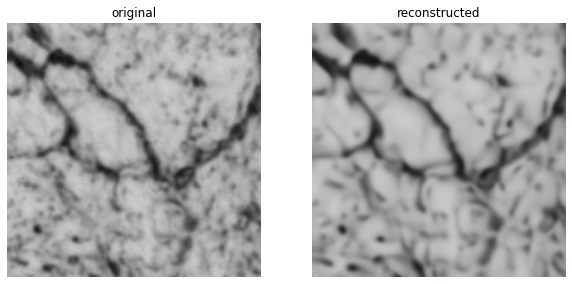

In [ ]:
micro_show_image(x, x_hat, idx=0)

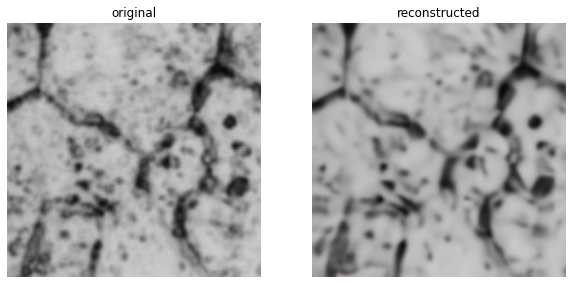

In [ ]:
micro_show_image(x, x_hat, idx=1)

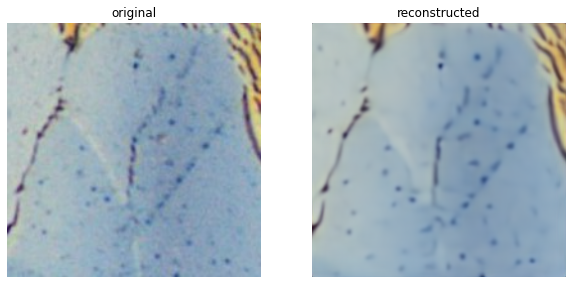

In [ ]:
micro_show_image(x, x_hat, idx=2)

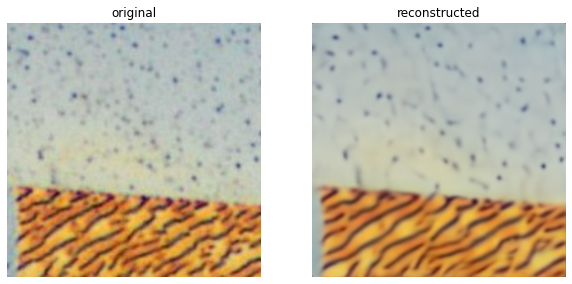

In [ ]:
micro_show_image(x, x_hat, idx=3)

In [ ]:
np.shape(latent_rep.parameters)

torch.Size([6, 128, 8, 8])

In [ ]:
#latent representation
print(np.shape(latent_rep.parameters[0]))
print(latent_rep.parameters[0][0])


torch.Size([128, 8, 8])
tensor([[ 2.5682,  1.3011,  2.0701,  2.2329,  1.8195,  2.1938,  1.5743,  1.6655],
        [ 0.8879,  1.1761,  0.7505,  2.0967,  2.4180,  1.4909,  0.6246,  2.4458],
        [ 1.6641, -0.4380,  1.7974,  0.5942,  0.8488,  1.6903,  1.3010,  1.6237],
        [ 0.9815,  1.6004, -0.1484,  2.0302,  0.0759,  1.0441,  0.2433,  0.2486],
        [ 2.3491,  1.2191,  1.6796,  0.6573,  0.4714,  0.4614,  0.7782,  0.5203],
        [ 2.2127,  1.3531,  1.3737,  0.9438,  2.5955,  1.7408,  1.0179,  0.6964],
        [ 1.3533,  1.8848,  0.6237,  0.9205,  0.8053,  1.2809,  0.9679,  1.2497],
        [ 1.1361,  0.5206,  1.6971,  0.7709,  0.6721,  0.4858,  2.0583,  1.5336]])


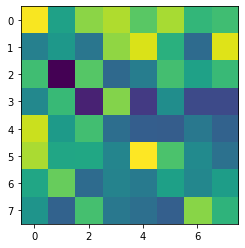

In [ ]:
#latent rep at
temp_rep = latent_rep.parameters[0]

fig = plt.figure()
plt.imshow(temp_rep[0].cpu().numpy())

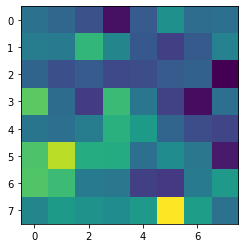

In [ ]:
#latent rep at
temp_rep = latent_rep.parameters[0]

fig = plt.figure()
plt.imshow(temp_rep[1].cpu().numpy())

## Interpolation Between Microstructure Classes

In [ ]:
def interpolate_btw_points(model, x1, x2, n_steps):
    mu1, logvar1 = model.encode(x1)
    z1 = model.reparameterize(mu1, logvar1)

    mu2, logvar2 = model.encode(x2)
    z2 = model.reparameterize(mu2, logvar2)
    
    # linear interpolate vectors
    ratios = np.linspace(0, 1, num=n_steps)
    points = [(1.0 - ratio) * z1 + ratio * z2 for ratio in ratios]
    points = torch.stack(points)

    new_imgs = [model.decode(point).squeeze_().detach().cpu() for point in points]


    return new_imgs

In [ ]:
# data
dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False, **kwargs)

In [ ]:
import time

num_epochs = 30
batch_size = 100
x_dim = 784
optimizers = autoencoder_model.configure_optimizers()[0]


In [ ]:
type(autoencoder_model)

__main__.AutoencoderKL

In [ ]:
for epoch in range(num_epochs):
  autoencoder_model.train()
  overall_loss = 0
  start_time = time.time()
  for batch_idx, (x, _) in enumerate(train_loader):
    for idx, optimizer in enumerate(optimizers):
      optimizer.zero_grad()
      loss = autoencoder_model.training_step(x, batch_idx, idx)
      loss.backward()
      overall_loss += loss
      optimizer.step()
  
  time_elapsed = time.time() - start_time
  model_name = f"KLAE_mnist_{epoch+1}epoch"
  PATH = f'/content/gdrive/MyDrive/capstone/{model_name}'
  torch.save(autoencoder_model.state_dict(), PATH)

  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
  print(f'\ttime_elaped for Epoch {epoch+1} = {time_elapsed}')

RuntimeError: ignored

In [ ]:
for epoch in range(num_epochs):
  autoencoder_model.train()
  overall_loss = 0
  start_time = time.time()
  for batch_idx, (x, _) in enumerate(train_loader):
    for idx, optimizer in enumerate(optimizers):
      optimizer.zero_grad()
      loss = autoencoder_model.training_step(x, batch_idx, idx)
      loss.backward()
      overall_loss += loss
      optimizer.step()
  
  time_elapsed = time.time() - start_time
  model_name = f"KLAE_mnist_{epoch+1}epoch"
  PATH = f'/content/gdrive/MyDrive/capstone/{model_name}'
  torch.save(autoencoder_model.state_dict(), PATH)
  
  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
  print(f'\ttime_elaped for Epoch {epoch+1} = {time_elapsed}')

In [ ]:
for epoch in range(1):
  autoencoder_model.train()
  overall_loss = 0
  start_time = time.time()
  for batch_idx, (x, _) in enumerate(train_loader):
    for idx, optimizer in enumerate(optimizers):
      optimizer.zero_grad()
      loss = autoencoder_model.training_step(x, batch_idx, idx)
      loss.backward()
      overall_loss += loss
      optimizer.step()
  
  time_elapsed = time.time() - start_time
  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
  print(f'\ttime_elaped for Epoch {epoch+1} = {time_elapsed}')



/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/module.py:377: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


	Epoch 1 complete! 	Average Loss:  tensor(1.1351, grad_fn=<DivBackward0>)
	time_elaped for Epoch 1 = 1874.5831768512726


In [ ]:
# visualize Autoencoder Architecture
!brew install graphviz
!pip install torchviz

/bin/bash: brew: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchviz import make_dot
autoencoder_model.eval()

temp_batch = next(iter(train_loader))[0]
yhat = autoencoder_model(temp_batch)

make_dot(yhat, params=dict(list(autoencoder_model.named_parameters()))).render("autoencoder_kl", format="png")

In [ ]:
temp = torch.Tensor([1,2,3])
temp

tensor([1., 2., 3.])

In [ ]:
np.array(temp).tolist()

[1.0, 2.0, 3.0]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_name = "KLVAE_mnist_1epoch"
PATH = f'/content/gdrive/MyDrive/capstone/{model_name}'
torch.save(autoencoder_model.state_dict(), PATH)

# Stage 3: Freeze Layers of AA

# Stage 4: Define DDPM

In [ ]:
ldm_config = {"base_learning_rate": 1.0e-6,
                      "target": "ldm.models.diffusion.ddpm.LatentDiffusion",
                      "params": {
                          "linear_start": 0.0015,
                          "linear_end": 0.0195,
                          "num_timesteps_cond": 1,
                          "log_every_t": 200,
                          "timesteps": 1000,
                          "first_stage_key": 'image',
                          'cond_stage_key': 'class_label',
                          'image_size': 7,
                          "channels": 2,
                          "cond_stage_trainable": "true",
                          "conditioning_key": "crossatn",
                          "monitor": "val/loss_simple_ema",
                          "unet_config": {
                              "target": "ldm.modules.diffusionmodules.openaimodel.UNetModel",
                              "params": {
                                  "image_size": 7,
                                  "in_channels": 2,
                                  "out_channels": 2,
                                  "model_channels": 28,
                                  "attention_resolutions": [4,2,1],
                                  "num_res_blocks": 2,
                                  "channel_mult": [1,2,4],
                                  "num_head_channels": 7,
                                  "use_spatial_transformer": "true",
                                  "transformer_depth": 1,
                                  "context_dim": 512
                              }
                          },
                          "first_stage_config": {
                              "target": "ldm.models.autoencoder.AutoencoderKL",
                              "params": {
                                  "monitor": "val/rec_loss",
                                  "embed_dim": 1,
                                  "ddconfig": {
                                      "double_z": True,
                                      "z_channels": 1,
                                      "resolution": 28,
                                      "in_channels": 1,
                                      "out_ch": 1,
                                      "ch": 16,
                                      "ch_mult": [ 1,2,4 ],  # num_down = len(ch_mult)-1
                                      "num_res_blocks": 2,
                                      "attn_resolutions": [ ],
                                      "dropout": 0.0 
                                  },
                                  "lossconfig": {
                                      "target": "torch.nn.Identity"
                                  }  
                              }
                          },
                          "cond_stage_config": {
                              "target": "ldm.modules.encoders.modules.ClassEmbedder",
                              "params": {
                                  "embed_dim": 512,
                                  "key": "class_label"
                              }
                          }
                      },
                      }

In [ ]:
import importlib

import torch
import numpy as np
from collections import abc
from einops import rearrange
from functools import partial

import multiprocessing as mp
from threading import Thread
from queue import Queue

from inspect import isfunction
from PIL import Image, ImageDraw, ImageFont


def log_txt_as_img(wh, xc, size=10):
    # wh a tuple of (width, height)
    # xc a list of captions to plot
    b = len(xc)
    txts = list()
    for bi in range(b):
        txt = Image.new("RGB", wh, color="white")
        draw = ImageDraw.Draw(txt)
        font = ImageFont.truetype('data/DejaVuSans.ttf', size=size)
        nc = int(40 * (wh[0] / 256))
        lines = "\n".join(xc[bi][start:start + nc] for start in range(0, len(xc[bi]), nc))

        try:
            draw.text((0, 0), lines, fill="black", font=font)
        except UnicodeEncodeError:
            print("Cant encode string for logging. Skipping.")

        txt = np.array(txt).transpose(2, 0, 1) / 127.5 - 1.0
        txts.append(txt)
    txts = np.stack(txts)
    txts = torch.tensor(txts)
    return txts


def ismap(x):
    if not isinstance(x, torch.Tensor):
        return False
    return (len(x.shape) == 4) and (x.shape[1] > 3)


def isimage(x):
    if not isinstance(x, torch.Tensor):
        return False
    return (len(x.shape) == 4) and (x.shape[1] == 3 or x.shape[1] == 1)


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def mean_flat(tensor):
    """
    https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/nn.py#L86
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params


class LitEma(nn.Module):
    def __init__(self, model, decay=0.9999, use_num_upates=True):
        super().__init__()
        if decay < 0.0 or decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')

        self.m_name2s_name = {}
        self.register_buffer('decay', torch.tensor(decay, dtype=torch.float32))
        self.register_buffer('num_updates', torch.tensor(0,dtype=torch.int) if use_num_upates
                             else torch.tensor(-1,dtype=torch.int))

        for name, p in model.named_parameters():
            if p.requires_grad:
                #remove as '.'-character is not allowed in buffers
                s_name = name.replace('.','')
                self.m_name2s_name.update({name:s_name})
                self.register_buffer(s_name,p.clone().detach().data)

        self.collected_params = []

    def forward(self,model):
        decay = self.decay

        if self.num_updates >= 0:
            self.num_updates += 1
            decay = min(self.decay,(1 + self.num_updates) / (10 + self.num_updates))

        one_minus_decay = 1.0 - decay

        with torch.no_grad():
            m_param = dict(model.named_parameters())
            shadow_params = dict(self.named_buffers())

            for key in m_param:
                if m_param[key].requires_grad:
                    sname = self.m_name2s_name[key]
                    shadow_params[sname] = shadow_params[sname].type_as(m_param[key])
                    shadow_params[sname].sub_(one_minus_decay * (shadow_params[sname] - m_param[key]))
                else:
                    assert not key in self.m_name2s_name

    def copy_to(self, model):
        m_param = dict(model.named_parameters())
        shadow_params = dict(self.named_buffers())
        for key in m_param:
            if m_param[key].requires_grad:
                m_param[key].data.copy_(shadow_params[self.m_name2s_name[key]].data)
            else:
                assert not key in self.m_name2s_name

    def store(self, parameters):
        """
        Save the current parameters for restoring later.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            temporarily stored.
        """
        self.collected_params = [param.clone() for param in parameters]

    def restore(self, parameters):
        """
        Restore the parameters stored with the `store` method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        `copy_to` method. After validation (or model saving), use this to
        restore the former parameters.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            updated with the stored parameters.
        """
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)

class IdentityFirstStage(torch.nn.Module):
    def __init__(self, *args, vq_interface=False, **kwargs):
        self.vq_interface = vq_interface  # TODO: Should be true by default but check to not break older stuff
        super().__init__()

    def encode(self, x, *args, **kwargs):
        return x

    def decode(self, x, *args, **kwargs):
        return x

    def quantize(self, x, *args, **kwargs):
        if self.vq_interface:
            return x, None, [None, None, None]
        return x

    def forward(self, x, *args, **kwargs):
        return x


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == "linear":
        betas = (
                torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2
        )

    elif schedule == "cosine":
        timesteps = (
                torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64)
    elif schedule == "sqrt":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64) ** 0.5
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


def extract_into_tensor(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

## Section 4.1: DDPM()

In [ ]:
# Denoising Diffusion Probabilistic Model
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LambdaLR
from einops import rearrange, repeat
from contextlib import contextmanager
from functools import partial
from tqdm import tqdm
from torchvision.utils import make_grid
from PIL import Image
from pytorch_lightning.utilities.distributed import rank_zero_only



__conditioning_keys__ = {'concat': 'c_concat',
                         'crossattn': 'c_crossattn',
                         'adm': 'y'}


def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def uniform_on_device(r1, r2, shape, device):
    return (r1 - r2) * torch.rand(*shape, device=device) + r2


class DDPM(pl.LightningModule):
    # classic DDPM with Gaussian diffusion, in image space
    def __init__(self,
                 unet_config,
                 timesteps=1000,
                 beta_schedule="linear",
                 loss_type="l2",
                 ckpt_path=None,
                 ignore_keys=[],
                 load_only_unet=False,
                 monitor="val/loss",
                 use_ema=True,
                 first_stage_key="image",
                 image_size=256,
                 channels=3,
                 log_every_t=100,
                 clip_denoised=True,
                 linear_start=1e-4,
                 linear_end=2e-2,
                 cosine_s=8e-3,
                 given_betas=None,
                 original_elbo_weight=0.,
                 v_posterior=0.,  # weight for choosing posterior variance as sigma = (1-v) * beta_tilde + v * beta
                 l_simple_weight=1.,
                 conditioning_key=None,
                 parameterization="eps",  # all assuming fixed variance schedules
                 scheduler_config=None,
                 use_positional_encodings=False,
                 learn_logvar=False,
                 logvar_init=0.,
                 ):
        super().__init__()
        assert parameterization in ["eps", "x0"], 'currently only supporting "eps" and "x0"'
        self.parameterization = parameterization
        print(f"{self.__class__.__name__}: Running in {self.parameterization}-prediction mode")
        self.cond_stage_model = None
        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t
        self.first_stage_key = first_stage_key
        self.image_size = image_size  # try conv?
        self.channels = channels
        self.use_positional_encodings = use_positional_encodings
        self.model = DiffusionWrapper(unet_config, conditioning_key)
        count_params(self.model, verbose=True)
        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self.model)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        self.use_scheduler = scheduler_config is not None
        if self.use_scheduler:
            self.scheduler_config = scheduler_config

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        if monitor is not None:
            self.monitor = monitor
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys, only_model=load_only_unet)

        self.register_schedule(given_betas=given_betas, beta_schedule=beta_schedule, timesteps=timesteps,
                               linear_start=linear_start, linear_end=linear_end, cosine_s=cosine_s)

        self.loss_type = loss_type

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(fill_value=logvar_init, size=(self.num_timesteps,))
        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

    def register_schedule(self, given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        if exists(given_betas):
            betas = given_betas
        else:
            betas = make_beta_schedule(beta_schedule, timesteps, linear_start=linear_start, linear_end=linear_end,
                                       cosine_s=cosine_s)
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end
        assert alphas_cumprod.shape[0] == self.num_timesteps, 'alphas have to be defined for each timestep'

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (1. - alphas_cumprod_prev) / (
                    1. - alphas_cumprod) + self.v_posterior * betas
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

        if self.parameterization == "eps":
            lvlb_weights = self.betas ** 2 / (
                        2 * self.posterior_variance * to_torch(alphas) * (1 - self.alphas_cumprod))
        elif self.parameterization == "x0":
            lvlb_weights = 0.5 * np.sqrt(torch.Tensor(alphas_cumprod)) / (2. * 1 - torch.Tensor(alphas_cumprod))
        else:
            raise NotImplementedError("mu not supported")
        # TODO how to choose this term
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer('lvlb_weights', lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.model.parameters())
            self.model_ema.copy_to(self.model)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.model.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def init_from_ckpt(self, path, ignore_keys=list(), only_model=False):
        sd = torch.load(path, map_location="cpu")
        if "state_dict" in list(sd.keys()):
            sd = sd["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        missing, unexpected = self.load_state_dict(sd, strict=False) if not only_model else self.model.load_state_dict(
            sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
        if len(unexpected) > 0:
            print(f"Unexpected Keys: {unexpected}")

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start)
        variance = extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
                extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool):
        model_out = self.model(x, t)
        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, shape, return_intermediates=False):
        device = self.betas.device
        b = shape[0]
        img = torch.randn(shape, device=device)
        intermediates = [img]
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='Sampling t', total=self.num_timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long),
                                clip_denoised=self.clip_denoised)
            if i % self.log_every_t == 0 or i == self.num_timesteps - 1:
                intermediates.append(img)
        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, batch_size=16, return_intermediates=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size),
                                  return_intermediates=return_intermediates)

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise)

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == 'l1':
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == 'l2':
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(target, pred, reduction='none')
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_out = self.model(x_noisy, t)

        loss_dict = {}
        if self.parameterization == "eps":
            target = noise
        elif self.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(f"Paramterization {self.parameterization} not yet supported")

        loss = self.get_loss(model_out, target, mean=False).mean(dim=[1, 2, 3])

        log_prefix = 'train' if self.training else 'val'

        loss_dict.update({f'{log_prefix}/loss_simple': loss.mean()})
        loss_simple = loss.mean() * self.l_simple_weight

        loss_vlb = (self.lvlb_weights[t] * loss).mean()
        loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

        loss = loss_simple + self.original_elbo_weight * loss_vlb

        loss_dict.update({f'{log_prefix}/loss': loss})

        return loss, loss_dict

    def forward(self, x, *args, **kwargs):
        # b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
        # assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        return self.p_losses(x, t, *args, **kwargs)

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = rearrange(x, 'b h w c -> b c h w')
        x = x.to(memory_format=torch.contiguous_format).float()
        return x

    def shared_step(self, batch):
        x = self.get_input(batch, self.first_stage_key)
        loss, loss_dict = self(x)
        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.shared_step(batch)

        self.log_dict(loss_dict, prog_bar=True,
                      logger=True, on_step=True, on_epoch=True)

        self.log("global_step", self.global_step,
                 prog_bar=True, logger=True, on_step=True, on_epoch=False)

        if self.use_scheduler:
            lr = self.optimizers().param_groups[0]['lr']
            self.log('lr_abs', lr, prog_bar=True, logger=True, on_step=True, on_epoch=False)

        return loss

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        _, loss_dict_no_ema = self.shared_step(batch)
        with self.ema_scope():
            _, loss_dict_ema = self.shared_step(batch)
            loss_dict_ema = {key + '_ema': loss_dict_ema[key] for key in loss_dict_ema}
        self.log_dict(loss_dict_no_ema, prog_bar=False, logger=True, on_step=False, on_epoch=True)
        self.log_dict(loss_dict_ema, prog_bar=False, logger=True, on_step=False, on_epoch=True)

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self.model)

    def _get_rows_from_list(self, samples):
        n_imgs_per_row = len(samples)
        denoise_grid = rearrange(samples, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=2, sample=True, return_keys=None, **kwargs):
        log = dict()
        x = self.get_input(batch, self.first_stage_key)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        x = x.to(self.device)[:N]
        log["inputs"] = x

        # get diffusion row
        diffusion_row = list()
        x_start = x[:n_row]

        for t in range(self.num_timesteps):
            if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                t = t.to(self.device).long()
                noise = torch.randn_like(x_start)
                x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
                diffusion_row.append(x_noisy)

        log["diffusion_row"] = self._get_rows_from_list(diffusion_row)

        if sample:
            # get denoise row
            with self.ema_scope("Plotting"):
                samples, denoise_row = self.sample(batch_size=N, return_intermediates=True)

            log["samples"] = samples
            log["denoise_row"] = self._get_rows_from_list(denoise_row)

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}
        return log

    def configure_optimizers(self):
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            params = params + [self.logvar]
        opt = torch.optim.AdamW(params, lr=lr)
        return opt


class LatentDiffusion(DDPM):
    """main class"""
    def __init__(self,
                 first_stage_config,
                 cond_stage_config,
                 num_timesteps_cond=None,
                 cond_stage_key="image",
                 cond_stage_trainable=False,
                 concat_mode=True,
                 cond_stage_forward=None,
                 conditioning_key=None,
                 scale_factor=1.0,
                 scale_by_std=False,
                 *args, **kwargs):
        self.num_timesteps_cond = default(num_timesteps_cond, 1)
        self.scale_by_std = scale_by_std
        assert self.num_timesteps_cond <= kwargs['timesteps']
        # for backwards compatibility after implementation of DiffusionWrapper
        if conditioning_key is None:
            conditioning_key = 'concat' if concat_mode else 'crossattn'
        if cond_stage_config == '__is_unconditional__':
            conditioning_key = None
        
        # mustajab ~ added for no conditioning
        conditioning_key = None

        ckpt_path = kwargs.pop("ckpt_path", None)
        ignore_keys = kwargs.pop("ignore_keys", [])
        super().__init__(conditioning_key=conditioning_key, *args, **kwargs)
        self.concat_mode = concat_mode
        self.cond_stage_trainable = cond_stage_trainable
        self.cond_stage_key = cond_stage_key
        try:
            self.num_downs = len(first_stage_config.params.ddconfig.ch_mult) - 1
        except:
            self.num_downs = 0
        if not scale_by_std:
            self.scale_factor = scale_factor
        else:
            self.register_buffer('scale_factor', torch.tensor(scale_factor))
        self.instantiate_first_stage(first_stage_config)
        
        #self.instantiate_cond_stage(cond_stage_config)
        self.instantiate_cond_state(config="__is_unconditional__")
        self.cond_stage_forward = cond_stage_forward
        self.clip_denoised = False
        self.bbox_tokenizer = None  # # TODO: special class?

        self.restarted_from_ckpt = False
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys)
            self.restarted_from_ckpt = True

    def make_cond_schedule(self, ):
        self.cond_ids = torch.full(size=(self.num_timesteps,), fill_value=self.num_timesteps - 1, dtype=torch.long)
        ids = torch.round(torch.linspace(0, self.num_timesteps - 1, self.num_timesteps_cond)).long()
        self.cond_ids[:self.num_timesteps_cond] = ids

    @rank_zero_only
    @torch.no_grad()
    def on_train_batch_start(self, batch, batch_idx, dataloader_idx):
        # only for very first batch
        if self.scale_by_std and self.current_epoch == 0 and self.global_step == 0 and batch_idx == 0 and not self.restarted_from_ckpt:
            assert self.scale_factor == 1., 'rather not use custom rescaling and std-rescaling simultaneously'
            # set rescale weight to 1./std of encodings
            print("### USING STD-RESCALING ###")
            x = super().get_input(batch, self.first_stage_key)
            x = x.to(self.device)
            encoder_posterior = self.encode_first_stage(x)
            z = self.get_first_stage_encoding(encoder_posterior).detach()
            del self.scale_factor
            self.register_buffer('scale_factor', 1. / z.flatten().std())
            print(f"setting self.scale_factor to {self.scale_factor}")
            print("### USING STD-RESCALING ###")

    def register_schedule(self,
                          given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        super().register_schedule(given_betas, beta_schedule, timesteps, linear_start, linear_end, cosine_s)

        self.shorten_cond_schedule = self.num_timesteps_cond > 1
        if self.shorten_cond_schedule:
            self.make_cond_schedule()

    def instantiate_first_stage(self, config):
        model = instantiate_from_config(config)
        model_name = "KLVAE_mnist_1epoch"
        PATH = f'/content/gdrive/MyDrive/capstone/{model_name}'
        model.load_state_dict(torch.load(PATH))

        self.first_stage_model = model.eval()
        self.first_stage_model.train = disabled_train
        for param in self.first_stage_model.parameters():
            param.requires_grad = False

    def instantiate_cond_stage(self, config):
        if not self.cond_stage_trainable:
            if config == "__is_first_stage__":
                print("Using first stage also as cond stage.")
                self.cond_stage_model = self.first_stage_model
            elif config == "__is_unconditional__":
                print(f"Training {self.__class__.__name__} as an unconditional model.")
                self.cond_stage_model = None
                # self.be_unconditional = True
            else:
                model = instantiate_from_config(config)
                self.cond_stage_model = model.eval()
                self.cond_stage_model.train = disabled_train
                for param in self.cond_stage_model.parameters():
                    param.requires_grad = False
        else:
            assert config != '__is_first_stage__'
            assert config != '__is_unconditional__'
            model = instantiate_from_config(config)
            self.cond_stage_model = model

    def _get_denoise_row_from_list(self, samples, desc='', force_no_decoder_quantization=False):
        denoise_row = []
        for zd in tqdm(samples, desc=desc):
            denoise_row.append(self.decode_first_stage(zd.to(self.device),
                                                            force_not_quantize=force_no_decoder_quantization))
        n_imgs_per_row = len(denoise_row)
        denoise_row = torch.stack(denoise_row)  # n_log_step, n_row, C, H, W
        denoise_grid = rearrange(denoise_row, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    def get_first_stage_encoding(self, encoder_posterior):
        if isinstance(encoder_posterior, DiagonalGaussianDistribution):
            z = encoder_posterior.sample()
        elif isinstance(encoder_posterior, torch.Tensor):
            z = encoder_posterior
        else:
            raise NotImplementedError(f"encoder_posterior of type '{type(encoder_posterior)}' not yet implemented")
        return self.scale_factor * z

    def get_learned_conditioning(self, c):
        if self.cond_stage_forward is None:
            if hasattr(self.cond_stage_model, 'encode') and callable(self.cond_stage_model.encode):
                c = self.cond_stage_model.encode(c)
                if isinstance(c, DiagonalGaussianDistribution):
                    c = c.mode()
            else:
                c = self.cond_stage_model(c)
        else:
            assert hasattr(self.cond_stage_model, self.cond_stage_forward)
            c = getattr(self.cond_stage_model, self.cond_stage_forward)(c)
        return c

    def meshgrid(self, h, w):
        y = torch.arange(0, h).view(h, 1, 1).repeat(1, w, 1)
        x = torch.arange(0, w).view(1, w, 1).repeat(h, 1, 1)

        arr = torch.cat([y, x], dim=-1)
        return arr

    def delta_border(self, h, w):
        """
        :param h: height
        :param w: width
        :return: normalized distance to image border,
         wtith min distance = 0 at border and max dist = 0.5 at image center
        """
        lower_right_corner = torch.tensor([h - 1, w - 1]).view(1, 1, 2)
        arr = self.meshgrid(h, w) / lower_right_corner
        dist_left_up = torch.min(arr, dim=-1, keepdims=True)[0]
        dist_right_down = torch.min(1 - arr, dim=-1, keepdims=True)[0]
        edge_dist = torch.min(torch.cat([dist_left_up, dist_right_down], dim=-1), dim=-1)[0]
        return edge_dist

    def get_weighting(self, h, w, Ly, Lx, device):
        weighting = self.delta_border(h, w)
        weighting = torch.clip(weighting, self.split_input_params["clip_min_weight"],
                               self.split_input_params["clip_max_weight"], )
        weighting = weighting.view(1, h * w, 1).repeat(1, 1, Ly * Lx).to(device)

        if self.split_input_params["tie_braker"]:
            L_weighting = self.delta_border(Ly, Lx)
            L_weighting = torch.clip(L_weighting,
                                     self.split_input_params["clip_min_tie_weight"],
                                     self.split_input_params["clip_max_tie_weight"])

            L_weighting = L_weighting.view(1, 1, Ly * Lx).to(device)
            weighting = weighting * L_weighting
        return weighting

    def get_fold_unfold(self, x, kernel_size, stride, uf=1, df=1):  # todo load once not every time, shorten code !
        """
        :param x: img of size (bs, c, h, w)
        :return: n img crops of size (n, bs, c, kernel_size[0], kernel_size[1])
        """
        bs, nc, h, w = x.shape

        # number of crops in image
        Ly = (h - kernel_size[0]) // stride[0] + 1
        Lx = (w - kernel_size[1]) // stride[1] + 1

        if uf == 1 and df == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold = torch.nn.Fold(output_size=x.shape[2:], **fold_params)

            weighting = self.get_weighting(kernel_size[0], kernel_size[1], Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h, w)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0], kernel_size[1], Ly * Lx))

        elif uf > 1 and df == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold_params2 = dict(kernel_size=(kernel_size[0] * uf, kernel_size[0] * uf),
                                dilation=1, padding=0,
                                stride=(stride[0] * uf, stride[1] * uf))
            fold = torch.nn.Fold(output_size=(x.shape[2] * uf, x.shape[3] * uf), **fold_params2)

            weighting = self.get_weighting(kernel_size[0] * uf, kernel_size[1] * uf, Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h * uf, w * uf)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0] * uf, kernel_size[1] * uf, Ly * Lx))

        elif df > 1 and uf == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold_params2 = dict(kernel_size=(kernel_size[0] // df, kernel_size[0] // df),
                                dilation=1, padding=0,
                                stride=(stride[0] // df, stride[1] // df))
            fold = torch.nn.Fold(output_size=(x.shape[2] // df, x.shape[3] // df), **fold_params2)

            weighting = self.get_weighting(kernel_size[0] // df, kernel_size[1] // df, Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h // df, w // df)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0] // df, kernel_size[1] // df, Ly * Lx))

        else:
            raise NotImplementedError

        return fold, unfold, normalization, weighting

    @torch.no_grad()
    def get_input(self, batch, k, return_first_stage_outputs=False, force_c_encode=False,
                  cond_key=None, return_original_cond=False, bs=None):
        x = super().get_input(batch, k)
        if bs is not None:
            x = x[:bs]
        x = x.to(self.device)
        encoder_posterior = self.encode_first_stage(x)
        z = self.get_first_stage_encoding(encoder_posterior).detach()

        if self.model.conditioning_key is not None:
            if cond_key is None:
                cond_key = self.cond_stage_key
            if cond_key != self.first_stage_key:
                if cond_key in ['caption', 'coordinates_bbox']:
                    xc = batch[cond_key]
                elif cond_key == 'class_label':
                    xc = batch
                else:
                    xc = super().get_input(batch, cond_key).to(self.device)
            else:
                xc = x
            if not self.cond_stage_trainable or force_c_encode:
                if isinstance(xc, dict) or isinstance(xc, list):
                    # import pudb; pudb.set_trace()
                    c = self.get_learned_conditioning(xc)
                else:
                    c = self.get_learned_conditioning(xc.to(self.device))
            else:
                c = xc
            if bs is not None:
                c = c[:bs]

            if self.use_positional_encodings:
                pos_x, pos_y = self.compute_latent_shifts(batch)
                ckey = __conditioning_keys__[self.model.conditioning_key]
                c = {ckey: c, 'pos_x': pos_x, 'pos_y': pos_y}

        else:
            c = None
            xc = None
            if self.use_positional_encodings:
                pos_x, pos_y = self.compute_latent_shifts(batch)
                c = {'pos_x': pos_x, 'pos_y': pos_y}
        out = [z, c]
        if return_first_stage_outputs:
            xrec = self.decode_first_stage(z)
            out.extend([x, xrec])
        if return_original_cond:
            out.append(xc)
        return out

    @torch.no_grad()
    def decode_first_stage(self, z, predict_cids=False, force_not_quantize=False):
        if predict_cids:
            if z.dim() == 4:
                z = torch.argmax(z.exp(), dim=1).long()
            z = self.first_stage_model.quantize.get_codebook_entry(z, shape=None)
            z = rearrange(z, 'b h w c -> b c h w').contiguous()

        z = 1. / self.scale_factor * z

        if hasattr(self, "split_input_params"):
            if self.split_input_params["patch_distributed_vq"]:
                ks = self.split_input_params["ks"]  # eg. (128, 128)
                stride = self.split_input_params["stride"]  # eg. (64, 64)
                uf = self.split_input_params["vqf"]
                bs, nc, h, w = z.shape
                if ks[0] > h or ks[1] > w:
                    ks = (min(ks[0], h), min(ks[1], w))
                    print("reducing Kernel")

                if stride[0] > h or stride[1] > w:
                    stride = (min(stride[0], h), min(stride[1], w))
                    print("reducing stride")

                fold, unfold, normalization, weighting = self.get_fold_unfold(z, ks, stride, uf=uf)

                z = unfold(z)  # (bn, nc * prod(**ks), L)
                # 1. Reshape to img shape
                z = z.view((z.shape[0], -1, ks[0], ks[1], z.shape[-1]))  # (bn, nc, ks[0], ks[1], L )

                # 2. apply model loop over last dim
                if isinstance(self.first_stage_model, VQModelInterface):
                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i],
                                                                 force_not_quantize=predict_cids or force_not_quantize)
                                   for i in range(z.shape[-1])]
                else:

                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i])
                                   for i in range(z.shape[-1])]

                o = torch.stack(output_list, axis=-1)  # # (bn, nc, ks[0], ks[1], L)
                o = o * weighting
                # Reverse 1. reshape to img shape
                o = o.view((o.shape[0], -1, o.shape[-1]))  # (bn, nc * ks[0] * ks[1], L)
                # stitch crops together
                decoded = fold(o)
                decoded = decoded / normalization  # norm is shape (1, 1, h, w)
                return decoded
            else:
                if isinstance(self.first_stage_model, VQModelInterface):
                    return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
                else:
                    return self.first_stage_model.decode(z)

        else:
            if isinstance(self.first_stage_model, VQModelInterface):
                return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
            else:
                return self.first_stage_model.decode(z)

    # same as above but without decorator
    def differentiable_decode_first_stage(self, z, predict_cids=False, force_not_quantize=False):
        if predict_cids:
            if z.dim() == 4:
                z = torch.argmax(z.exp(), dim=1).long()
            z = self.first_stage_model.quantize.get_codebook_entry(z, shape=None)
            z = rearrange(z, 'b h w c -> b c h w').contiguous()

        z = 1. / self.scale_factor * z

        if hasattr(self, "split_input_params"):
            if self.split_input_params["patch_distributed_vq"]:
                ks = self.split_input_params["ks"]  # eg. (128, 128)
                stride = self.split_input_params["stride"]  # eg. (64, 64)
                uf = self.split_input_params["vqf"]
                bs, nc, h, w = z.shape
                if ks[0] > h or ks[1] > w:
                    ks = (min(ks[0], h), min(ks[1], w))
                    print("reducing Kernel")

                if stride[0] > h or stride[1] > w:
                    stride = (min(stride[0], h), min(stride[1], w))
                    print("reducing stride")

                fold, unfold, normalization, weighting = self.get_fold_unfold(z, ks, stride, uf=uf)

                z = unfold(z)  # (bn, nc * prod(**ks), L)
                # 1. Reshape to img shape
                z = z.view((z.shape[0], -1, ks[0], ks[1], z.shape[-1]))  # (bn, nc, ks[0], ks[1], L )

                # 2. apply model loop over last dim
                if isinstance(self.first_stage_model, VQModelInterface):  # todo ask what this is
                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i],
                                                                 force_not_quantize=predict_cids or force_not_quantize)
                                   for i in range(z.shape[-1])]
                else:

                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i])
                                   for i in range(z.shape[-1])]

                o = torch.stack(output_list, axis=-1)  # # (bn, nc, ks[0], ks[1], L)
                o = o * weighting
                # Reverse 1. reshape to img shape
                o = o.view((o.shape[0], -1, o.shape[-1]))  # (bn, nc * ks[0] * ks[1], L)
                # stitch crops together
                decoded = fold(o)
                decoded = decoded / normalization  # norm is shape (1, 1, h, w)
                return decoded
            else:
                if isinstance(self.first_stage_model, VQModelInterface):
                    return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
                else:
                    return self.first_stage_model.decode(z)

        else:
            if isinstance(self.first_stage_model, VQModelInterface):
                return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
            else:
                return self.first_stage_model.decode(z)

    @torch.no_grad()
    def encode_first_stage(self, x):
        if hasattr(self, "split_input_params"):
            if self.split_input_params["patch_distributed_vq"]:
                ks = self.split_input_params["ks"]  # eg. (128, 128)
                stride = self.split_input_params["stride"]  # eg. (64, 64)
                df = self.split_input_params["vqf"]
                self.split_input_params['original_image_size'] = x.shape[-2:]
                bs, nc, h, w = x.shape
                if ks[0] > h or ks[1] > w:
                    ks = (min(ks[0], h), min(ks[1], w))
                    print("reducing Kernel")

                if stride[0] > h or stride[1] > w:
                    stride = (min(stride[0], h), min(stride[1], w))
                    print("reducing stride")

                fold, unfold, normalization, weighting = self.get_fold_unfold(x, ks, stride, df=df)
                z = unfold(x)  # (bn, nc * prod(**ks), L)
                # Reshape to img shape
                z = z.view((z.shape[0], -1, ks[0], ks[1], z.shape[-1]))  # (bn, nc, ks[0], ks[1], L )

                output_list = [self.first_stage_model.encode(z[:, :, :, :, i])
                               for i in range(z.shape[-1])]

                o = torch.stack(output_list, axis=-1)
                o = o * weighting

                # Reverse reshape to img shape
                o = o.view((o.shape[0], -1, o.shape[-1]))  # (bn, nc * ks[0] * ks[1], L)
                # stitch crops together
                decoded = fold(o)
                decoded = decoded / normalization
                return decoded

            else:
                return self.first_stage_model.encode(x)
        else:
            return self.first_stage_model.encode(x)

    def shared_step(self, batch, **kwargs):
        x, c = self.get_input(batch, self.first_stage_key)
        loss = self(x, c)
        return loss

    def forward(self, x, c, *args, **kwargs):
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        if self.model.conditioning_key is not None:
            assert c is not None
            if self.cond_stage_trainable:
                c = self.get_learned_conditioning(c)
            if self.shorten_cond_schedule:  # TODO: drop this option
                tc = self.cond_ids[t].to(self.device)
                c = self.q_sample(x_start=c, t=tc, noise=torch.randn_like(c.float()))
        return self.p_losses(x, c, t, *args, **kwargs)

    def _rescale_annotations(self, bboxes, crop_coordinates):  # TODO: move to dataset
        def rescale_bbox(bbox):
            x0 = clamp((bbox[0] - crop_coordinates[0]) / crop_coordinates[2])
            y0 = clamp((bbox[1] - crop_coordinates[1]) / crop_coordinates[3])
            w = min(bbox[2] / crop_coordinates[2], 1 - x0)
            h = min(bbox[3] / crop_coordinates[3], 1 - y0)
            return x0, y0, w, h

        return [rescale_bbox(b) for b in bboxes]

    def apply_model(self, x_noisy, t, cond, return_ids=False):

        if isinstance(cond, dict):
            # hybrid case, cond is exptected to be a dict
            pass
        else:
            if not isinstance(cond, list):
                cond = [cond]
            key = 'c_concat' if self.model.conditioning_key == 'concat' else 'c_crossattn'
            cond = {key: cond}

        if hasattr(self, "split_input_params"):
            assert len(cond) == 1  # todo can only deal with one conditioning atm
            assert not return_ids  # todo dont know what this is -> I exclude --> Good
            ks = self.split_input_params["ks"]  # eg. (128, 128)
            stride = self.split_input_params["stride"]  # eg. (64, 64)

            h, w = x_noisy.shape[-2:]

            fold, unfold, normalization, weighting = self.get_fold_unfold(x_noisy, ks, stride)

            z = unfold(x_noisy)  # (bn, nc * prod(**ks), L)
            # Reshape to img shape
            z = z.view((z.shape[0], -1, ks[0], ks[1], z.shape[-1]))  # (bn, nc, ks[0], ks[1], L )
            z_list = [z[:, :, :, :, i] for i in range(z.shape[-1])]

            if self.cond_stage_key in ["image", "LR_image", "segmentation",
                                       'bbox_img'] and self.model.conditioning_key:  # todo check for completeness
                c_key = next(iter(cond.keys()))  # get key
                c = next(iter(cond.values()))  # get value
                assert (len(c) == 1)  # todo extend to list with more than one elem
                c = c[0]  # get element

                c = unfold(c)
                c = c.view((c.shape[0], -1, ks[0], ks[1], c.shape[-1]))  # (bn, nc, ks[0], ks[1], L )

                cond_list = [{c_key: [c[:, :, :, :, i]]} for i in range(c.shape[-1])]

            elif self.cond_stage_key == 'coordinates_bbox':
                assert 'original_image_size' in self.split_input_params, 'BoudingBoxRescaling is missing original_image_size'

                # assuming padding of unfold is always 0 and its dilation is always 1
                n_patches_per_row = int((w - ks[0]) / stride[0] + 1)
                full_img_h, full_img_w = self.split_input_params['original_image_size']
                # as we are operating on latents, we need the factor from the original image size to the
                # spatial latent size to properly rescale the crops for regenerating the bbox annotations
                num_downs = self.first_stage_model.encoder.num_resolutions - 1
                rescale_latent = 2 ** (num_downs)

                # get top left postions of patches as conforming for the bbbox tokenizer, therefore we
                # need to rescale the tl patch coordinates to be in between (0,1)
                tl_patch_coordinates = [(rescale_latent * stride[0] * (patch_nr % n_patches_per_row) / full_img_w,
                                         rescale_latent * stride[1] * (patch_nr // n_patches_per_row) / full_img_h)
                                        for patch_nr in range(z.shape[-1])]

                # patch_limits are tl_coord, width and height coordinates as (x_tl, y_tl, h, w)
                patch_limits = [(x_tl, y_tl,
                                 rescale_latent * ks[0] / full_img_w,
                                 rescale_latent * ks[1] / full_img_h) for x_tl, y_tl in tl_patch_coordinates]
                # patch_values = [(np.arange(x_tl,min(x_tl+ks, 1.)),np.arange(y_tl,min(y_tl+ks, 1.))) for x_tl, y_tl in tl_patch_coordinates]

                # tokenize crop coordinates for the bounding boxes of the respective patches
                patch_limits_tknzd = [torch.LongTensor(self.bbox_tokenizer._crop_encoder(bbox))[None].to(self.device)
                                      for bbox in patch_limits]  # list of length l with tensors of shape (1, 2)
                print(patch_limits_tknzd[0].shape)
                # cut tknzd crop position from conditioning
                assert isinstance(cond, dict), 'cond must be dict to be fed into model'
                cut_cond = cond['c_crossattn'][0][..., :-2].to(self.device)
                print(cut_cond.shape)

                adapted_cond = torch.stack([torch.cat([cut_cond, p], dim=1) for p in patch_limits_tknzd])
                adapted_cond = rearrange(adapted_cond, 'l b n -> (l b) n')
                print(adapted_cond.shape)
                adapted_cond = self.get_learned_conditioning(adapted_cond)
                print(adapted_cond.shape)
                adapted_cond = rearrange(adapted_cond, '(l b) n d -> l b n d', l=z.shape[-1])
                print(adapted_cond.shape)

                cond_list = [{'c_crossattn': [e]} for e in adapted_cond]

            else:
                cond_list = [cond for i in range(z.shape[-1])]  # Todo make this more efficient

            # apply model by loop over crops
            output_list = [self.model(z_list[i], t, **cond_list[i]) for i in range(z.shape[-1])]
            assert not isinstance(output_list[0],
                                  tuple)  # todo cant deal with multiple model outputs check this never happens

            o = torch.stack(output_list, axis=-1)
            o = o * weighting
            # Reverse reshape to img shape
            o = o.view((o.shape[0], -1, o.shape[-1]))  # (bn, nc * ks[0] * ks[1], L)
            # stitch crops together
            x_recon = fold(o) / normalization

        else:
            x_recon = self.model(x_noisy, t, **cond)

        if isinstance(x_recon, tuple) and not return_ids:
            return x_recon[0]
        else:
            return x_recon

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart) / \
               extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.
        This term can't be optimized, as it only depends on the encoder.
        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0)
        return mean_flat(kl_prior) / np.log(2.0)

    def p_losses(self, x_start, cond, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_output = self.apply_model(x_noisy, t, cond)

        loss_dict = {}
        prefix = 'train' if self.training else 'val'

        if self.parameterization == "x0":
            target = x_start
        elif self.parameterization == "eps":
            target = noise
        else:
            raise NotImplementedError()

        loss_simple = self.get_loss(model_output, target, mean=False).mean([1, 2, 3])
        loss_dict.update({f'{prefix}/loss_simple': loss_simple.mean()})

        logvar_t = self.logvar[t].to(self.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        # loss = loss_simple / torch.exp(self.logvar) + self.logvar
        if self.learn_logvar:
            loss_dict.update({f'{prefix}/loss_gamma': loss.mean()})
            loss_dict.update({'logvar': self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(dim=(1, 2, 3))
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f'{prefix}/loss_vlb': loss_vlb})
        loss += (self.original_elbo_weight * loss_vlb)
        loss_dict.update({f'{prefix}/loss': loss})

        return loss, loss_dict

    def p_mean_variance(self, x, c, t, clip_denoised: bool, return_codebook_ids=False, quantize_denoised=False,
                        return_x0=False, score_corrector=None, corrector_kwargs=None):
        t_in = t
        model_out = self.apply_model(x, t_in, c, return_ids=return_codebook_ids)

        if score_corrector is not None:
            assert self.parameterization == "eps"
            model_out = score_corrector.modify_score(self, model_out, x, t, c, **corrector_kwargs)

        if return_codebook_ids:
            model_out, logits = model_out

        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        else:
            raise NotImplementedError()

        if clip_denoised:
            x_recon.clamp_(-1., 1.)
        if quantize_denoised:
            x_recon, _, [_, _, indices] = self.first_stage_model.quantize(x_recon)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        if return_codebook_ids:
            return model_mean, posterior_variance, posterior_log_variance, logits
        elif return_x0:
            return model_mean, posterior_variance, posterior_log_variance, x_recon
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, c, t, clip_denoised=False, repeat_noise=False,
                 return_codebook_ids=False, quantize_denoised=False, return_x0=False,
                 temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None):
        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(x=x, c=c, t=t, clip_denoised=clip_denoised,
                                       return_codebook_ids=return_codebook_ids,
                                       quantize_denoised=quantize_denoised,
                                       return_x0=return_x0,
                                       score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
        if return_codebook_ids:
            raise DeprecationWarning("Support dropped.")
            model_mean, _, model_log_variance, logits = outputs
        elif return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))

        if return_codebook_ids:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, logits.argmax(dim=1)
        if return_x0:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, x0
        else:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def progressive_denoising(self, cond, shape, verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=None, x_T=None, start_T=None,
                              log_every_t=None):
        if not log_every_t:
            log_every_t = self.log_every_t
        timesteps = self.num_timesteps
        if batch_size is not None:
            b = batch_size if batch_size is not None else shape[0]
            shape = [batch_size] + list(shape)
        else:
            b = batch_size = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=self.device)
        else:
            img = x_T
        intermediates = []
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Progressive Generation',
                        total=timesteps) if verbose else reversed(
            range(0, timesteps))
        if type(temperature) == float:
            temperature = [temperature] * timesteps

        for i in iterator:
            ts = torch.full((b,), i, device=self.device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img, x0_partial = self.p_sample(img, cond, ts,
                                            clip_denoised=self.clip_denoised,
                                            quantize_denoised=quantize_denoised, return_x0=True,
                                            temperature=temperature[i], noise_dropout=noise_dropout,
                                            score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
            if mask is not None:
                assert x0 is not None
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(x0_partial)
            if callback: callback(i)
            if img_callback: img_callback(img, i)
        return img, intermediates

    @torch.no_grad()
    def p_sample_loop(self, cond, shape, return_intermediates=False,
                      x_T=None, verbose=True, callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, start_T=None,
                      log_every_t=None):

        if not log_every_t:
            log_every_t = self.log_every_t
        device = self.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        intermediates = [img]
        if timesteps is None:
            timesteps = self.num_timesteps

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        print(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Sampling t', total=timesteps) if verbose else reversed(
            range(0, timesteps))

        if mask is not None:
            assert x0 is not None
            assert x0.shape[2:3] == mask.shape[2:3]  # spatial size has to match

        for i in iterator:
            ts = torch.full((b,), i, device=device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img = self.p_sample(img, cond, ts,
                                clip_denoised=self.clip_denoised,
                                quantize_denoised=quantize_denoised)
            if mask is not None:
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(img)
            if callback: callback(i)
            if img_callback: img_callback(img, i)

        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, cond, batch_size=16, return_intermediates=False, x_T=None,
               verbose=True, timesteps=None, quantize_denoised=False,
               mask=None, x0=None, shape=None):
        if shape is None:
            shape = (batch_size, self.channels, self.image_size, self.image_size)
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]
        return self.p_sample_loop(cond,
                                  shape,
                                  return_intermediates=return_intermediates, x_T=x_T,
                                  verbose=verbose, timesteps=timesteps, quantize_denoised=quantize_denoised,
                                  mask=mask, x0=x0)

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=4, sample=True, sample_ddim=False, return_keys=None,
                   quantize_denoised=True, inpaint=True, plot_denoise_rows=False, plot_progressive_rows=True,
                   plot_diffusion_rows=True, **kwargs):
        # TODO: maybe add option for ddim sampling via DDIMSampler class
        log = dict()
        z, c, x, xrec, xc = self.get_input(batch, self.first_stage_key,
                                           return_first_stage_outputs=True,
                                           force_c_encode=True,
                                           return_original_cond=True,
                                           bs=N)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        log["inputs"] = x
        log["reconstruction"] = xrec
        if self.model.conditioning_key is not None:
            if hasattr(self.cond_stage_model, "decode"):
                xc = self.cond_stage_model.decode(c)
                log["conditioning"] = xc
            elif self.cond_stage_key in ["caption"]:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["caption"])
                log["conditioning"] = xc
            elif self.cond_stage_key == 'class_label':
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["human_label"])
                log['conditioning'] = xc
            elif isimage(xc):
                log["conditioning"] = xc
            if ismap(xc):
                log["original_conditioning"] = self.to_rgb(xc)

        if plot_diffusion_rows:
            # get diffusion row
            diffusion_row = list()
            z_start = z[:n_row]
            for t in range(self.num_timesteps):
                if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                    t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                    t = t.to(self.device).long()
                    noise = torch.randn_like(z_start)
                    z_noisy = self.q_sample(x_start=z_start, t=t, noise=noise)
                    diffusion_row.append(self.decode_first_stage(z_noisy))

            diffusion_row = torch.stack(diffusion_row)  # n_log_step, n_row, C, H, W
            diffusion_grid = rearrange(diffusion_row, 'n b c h w -> b n c h w')
            diffusion_grid = rearrange(diffusion_grid, 'b n c h w -> (b n) c h w')
            diffusion_grid = make_grid(diffusion_grid, nrow=diffusion_row.shape[0])
            log["diffusion_row"] = diffusion_grid

        if sample:
            # get denoise row
            with self.ema_scope("Plotting"):
                samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True)
            x_samples = self.decode_first_stage(samples)
            log["samples"] = x_samples
            if plot_denoise_rows:
                denoise_grid = self._get_denoise_row_from_list(z_denoise_row)
                log["denoise_row"] = denoise_grid

            if quantize_denoised and not isinstance(self.first_stage_model, AutoencoderKL) and not isinstance(
                    self.first_stage_model, IdentityFirstStage):
                # also display when quantizing x0 while sampling
                with self.ema_scope("Plotting Quantized Denoised"):
                    samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True,
                                                         quantize_denoised=True)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_x0_quantized"] = x_samples

            if inpaint:
                # make a simple center square
                b, h, w = z.shape[0], z.shape[2], z.shape[3]
                mask = torch.ones(N, h, w).to(self.device)
                # zeros will be filled in
                mask[:, h // 4:3 * h // 4, w // 4:3 * w // 4] = 0.
                mask = mask[:, None, ...]
                with self.ema_scope("Plotting Inpaint"):
                    samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True,
                                                         quantize_denoised=False, x0=z[:N], mask=mask)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_inpainting"] = x_samples
                log["mask"] = mask
                if plot_denoise_rows:
                    denoise_grid = self._get_denoise_row_from_list(z_denoise_row)
                    log["denoise_row_inpainting"] = denoise_grid

                # outpaint
                with self.ema_scope("Plotting Outpaint"):
                    samples = self.sample(cond=c, batch_size=N, return_intermediates=False,
                                          quantize_denoised=False, x0=z[:N], mask=1. - mask)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_outpainting"] = x_samples

        if plot_progressive_rows:
            with self.ema_scope("Plotting Progressives"):
                img, progressives = self.progressive_denoising(c,
                                                               shape=(self.channels, self.image_size, self.image_size),
                                                               batch_size=N)
            prog_row = self._get_denoise_row_from_list(progressives, desc="Progressive Generation")
            log["progressive_row"] = prog_row

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}
        return log

    def configure_optimizers(self):
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.cond_stage_trainable:
            print(f"{self.__class__.__name__}: Also optimizing conditioner params!")
            params = params + list(self.cond_stage_model.parameters())
        if self.learn_logvar:
            print('Diffusion model optimizing logvar')
            params.append(self.logvar)
        opt = torch.optim.AdamW(params, lr=lr)
        if self.use_scheduler:
            assert 'target' in self.scheduler_config
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                }]
            return [opt], scheduler
        return opt

    @torch.no_grad()
    def to_rgb(self, x):
        x = x.float()
        if not hasattr(self, "colorize"):
            self.colorize = torch.randn(3, x.shape[1], 1, 1).to(x)
        x = nn.functional.conv2d(x, weight=self.colorize)
        x = 2. * (x - x.min()) / (x.max() - x.min()) - 1.
        return x

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


In [ ]:
class DiffusionWrapper(pl.LightningModule):
    def __init__(self, diff_model_config, conditioning_key):
        super().__init__()
        #self.diffusion_model = instantiate_from_config(diff_model_config)
        self.diffusion_model = UNetModel(diff_model_config["params"]["image_size"], diff_model_config["params"]["in_channels"], diff_model_config["params"]["model_channels"], diff_model_config["params"]["out_channels"], diff_model_config["params"]["num_res_blocks"], diff_model_config["params"]["attention_resolutions"], channel_mult=(1,2,4), num_head_channels=7)
        self.conditioning_key = conditioning_key
        assert self.conditioning_key in [None, 'concat', 'crossattn', 'hybrid', 'adm']

    def forward(self, x, t, c_concat: list = None, c_crossattn: list = None):
        if self.conditioning_key is None:
            out = self.diffusion_model(x, t)
        elif self.conditioning_key == 'concat':
            xc = torch.cat([x] + c_concat, dim=1)
            out = self.diffusion_model(xc, t)
        elif self.conditioning_key == 'crossattn':
            cc = torch.cat(c_crossattn, 1)
            out = self.diffusion_model(x, t, context=cc)
        elif self.conditioning_key == 'hybrid':
            xc = torch.cat([x] + c_concat, dim=1)
            cc = torch.cat(c_crossattn, 1)
            out = self.diffusion_model(xc, t, context=cc)
        elif self.conditioning_key == 'adm':
            cc = c_crossattn[0]
            out = self.diffusion_model(x, t, y=cc)
        else:
            raise NotImplementedError()

        return out

## Section 4.2 U-Net Architecture

In [ ]:
from abc import abstractmethod
from functools import partial
import math
from typing import Iterable

import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.
    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])

        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def normalization(channels):
    """
    Make a standard normalization layer.
    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    else:
        embedding = repeat(timesteps, 'b -> b d', d=dim)
    return embedding

### Section 4.2.1 UNet()

In [ ]:
class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        use_spatial_transformer=False,    # custom transformer support
        transformer_depth=1,              # custom transformer support
        context_dim=None,                 # custom transformer support
        n_embed=None                      # custom support for prediction of discrete ids into codebook of first stage vq model
    ):
        super().__init__()

        if use_spatial_transformer:
            assert context_dim is not None, 'Fool!! You forgot to include the dimension of your cross-attention conditioning...'

        if context_dim is not None:
            assert use_spatial_transformer, 'Fool!! You forgot to use the spatial transformer for your cross-attention conditioning...'



        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample
        self.predict_codebook_ids = n_embed is not None

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        self._feature_size = model_channels
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    dim_head = ch // num_heads
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        dim_head = ch // num_heads
        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim
                        ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=model_channels * mult,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    dim_head = ch // num_heads
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),
        )
        if self.predict_codebook_ids:
            self.id_predictor = nn.Sequential(
            normalization(ch),
            conv_nd(dims, model_channels, n_embed, 1),
            #nn.LogSoftmax(dim=1)  # change to cross_entropy and produce non-normalized logits
        )

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, x, timesteps=None, context=None, y=None,**kwargs):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param context: conditioning plugged in via crossattn
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        assert timesteps is not None, 'need to implement no-timestep usage'
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb, context)
        h = h.type(x.dtype)
        if self.predict_codebook_ids:
            #return self.out(h), self.id_predictor(h)
            return self.id_predictor(h)
        else:
            return self.out(h)

In [ ]:
def exists(val):
    return val is not None


def uniq(arr):
    return{el: True for el in arr}.keys()


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def max_neg_value(t):
    return -torch.finfo(t.dtype).max


def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor


# feedforward
class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class FeedForward(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4, glu=False, dropout=0.):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)
        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU()
        ) if not glu else GEGLU(dim, inner_dim)

        self.net = nn.Sequential(
            project_in,
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out)
        )

    def forward(self, x):
        return self.net(x)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)  
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)


class SpatialSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = rearrange(q, 'b c h w -> b (h w) c')
        k = rearrange(k, 'b c h w -> b c (h w)')
        w_ = torch.einsum('bij,bjk->bik', q, k)

        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = rearrange(v, 'b c h w -> b c (h w)')
        w_ = rearrange(w_, 'b i j -> b j i')
        h_ = torch.einsum('bij,bjk->bik', v, w_)
        h_ = rearrange(h_, 'b c (h w) -> b c h w', h=h)
        h_ = self.proj_out(h_)

        return x+h_


class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)


class BasicTransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, d_head, dropout=0., context_dim=None, gated_ff=True, checkpoint=True):
        super().__init__()
        self.attn1 = CrossAttention(query_dim=dim, heads=n_heads, dim_head=d_head, dropout=dropout)  # is a self-attention
        self.ff = FeedForward(dim, dropout=dropout, glu=gated_ff)
        self.attn2 = CrossAttention(query_dim=dim, context_dim=context_dim,
                                    heads=n_heads, dim_head=d_head, dropout=dropout)  # is self-attn if context is none
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.checkpoint = checkpoint

    def forward(self, x, context=None):
        return checkpoint(self._forward, (x, context), self.parameters(), self.checkpoint)

    def _forward(self, x, context=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    """
    Transformer block for image-like data.
    First, project the input (aka embedding)
    and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image
    """
    def __init__(self, in_channels, n_heads, d_head,
                 depth=1, dropout=0., context_dim=None):
        super().__init__()
        self.in_channels = in_channels
        inner_dim = n_heads * d_head
        self.norm = Normalize(in_channels)

        self.proj_in = nn.Conv2d(in_channels,
                                 inner_dim,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)

        self.transformer_blocks = nn.ModuleList(
            [BasicTransformerBlock(inner_dim, n_heads, d_head, dropout=dropout, context_dim=context_dim)
                for d in range(depth)]
        )

        self.proj_out = zero_module(nn.Conv2d(inner_dim,
                                              in_channels,
                                              kernel_size=1,
                                              stride=1,
                                              padding=0))

    def forward(self, x, context=None):
        # note: if no context is given, cross-attention defaults to self-attention
        b, c, h, w = x.shape
        x_in = x
        x = self.norm(x)
        x = self.proj_in(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        for block in self.transformer_blocks:
            x = block(x, context=context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.proj_out(x)
        return x + x_in

In [ ]:
# dummy replace
def convert_module_to_f16(x):
    pass

def convert_module_to_f32(x):
    pass


## go
class AttentionPool2d(nn.Module):
    """
    Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py
    """

    def __init__(
        self,
        spacial_dim: int,
        embed_dim: int,
        num_heads_channels: int,
        output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(th.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5)
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, context)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=padding)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class TransposedUpsample(nn.Module):
    'Learned 2x upsampling without padding'
    def __init__(self, channels, out_channels=None, ks=5):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels

        self.up = nn.ConvTranspose2d(self.channels,self.out_channels,kernel_size=ks,stride=2)

    def forward(self,x):
        return self.up(x)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None,padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_channels, 3, stride=stride, padding=padding
            )
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )


    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)   # TODO: check checkpoint usage, is True # TODO: fix the .half call!!!
        #return pt_checkpoint(self._forward, x)  # pytorch

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)

# Section 5: Train LDM

In [ ]:
ldm_model = LatentDiffusion(first_stage_config=ldm_config["params"]["first_stage_config"], cond_stage_config=ldm_config["params"]["cond_stage_config"], unet_config=ldm_config["params"]["unet_config"])
























